# CAISO Energy Storage Bid Analysis

<b>Author:</b> Neal Ma

<b>Date Created:</b> October 1, 2024

<b>Description:</b> This notebook analyzes CAISO Energy Storage bid data obtained from CAISO Daily Energy Storage Reports.

CAISO Average Price Data from LCG Consulting (http://www.energyonline.com/Data/GenericData.aspx?DataId=20)

In [34]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import matplotlib.dates as mdates
import math

# enable tex for graphs
matplotlib.rc("text", usetex=True)
matplotlib.rc("font", family="serif")

## Data Intake and General Definitions

In [35]:
data_path = "./data/ES_BIDS/"
df = pd.read_parquet(data_path + "CAISO_ES_BIDS.parquet")

caiso_avg_price_df = pd.read_csv("./data/CAISOAvgPrice.csv")
caiso_avg_price_df["date"] = pd.to_datetime(caiso_avg_price_df["date"])
caiso_avg_price_df.set_index("date", inplace=True)
df = df.merge(caiso_avg_price_df, left_index=True, right_index=True, how="left")

C:\Users\Astro\AppData\Local\Temp\ipykernel_29716\2935140400.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  caiso_avg_price_df["date"] = pd.to_datetime(caiso_avg_price_df["date"])


In [36]:
bid_cols = [col for col in df.columns if "bid" in col]

bid_segments = {
    "ss": "Self Schedule",
    "1": "[-150, -100]",
    "2": "(-100, -50]",
    "3": "(-50, -15]",
    "4": "(-15, 0]",
    "5": "(0, 15]",
    "6": "(15, 50]",
    "7": "(50, 100]",
    "8": "(100, 200]",
    "9": "(200, 500]",
    "10": "(500, 1000]",
    "11": "(1000, 2000]",
}

In [37]:
AGGREGATION_GRANULARITY = "D"

# plot the capacity-normalized bids for every segment aggregated daily
bid_columns = [col for col in df.columns if "bid" in col] + ["price"]

# aggregate daily capacities (time-based average) from df
df_daily_aggregate = df.resample(AGGREGATION_GRANULARITY).mean()
df_daily_aggregate["bid_rtpd_neg_tot"] = sum(
    [df_daily_aggregate[col_name] for col_name in bid_columns if "rtpd_neg" in col_name]
)
df_daily_aggregate["bid_rtpd_pos_tot"] = sum(
    [df_daily_aggregate[col_name] for col_name in bid_columns if "rtpd_pos" in col_name]
)
df_daily_aggregate["bid_ifm_neg_tot"] = sum(
    [df_daily_aggregate[col_name] for col_name in bid_columns if "ifm_neg" in col_name]
)
df_daily_aggregate["bid_ifm_pos_tot"] = sum(
    [df_daily_aggregate[col_name] for col_name in bid_columns if "ifm_pos" in col_name]
)

## Data Exploration

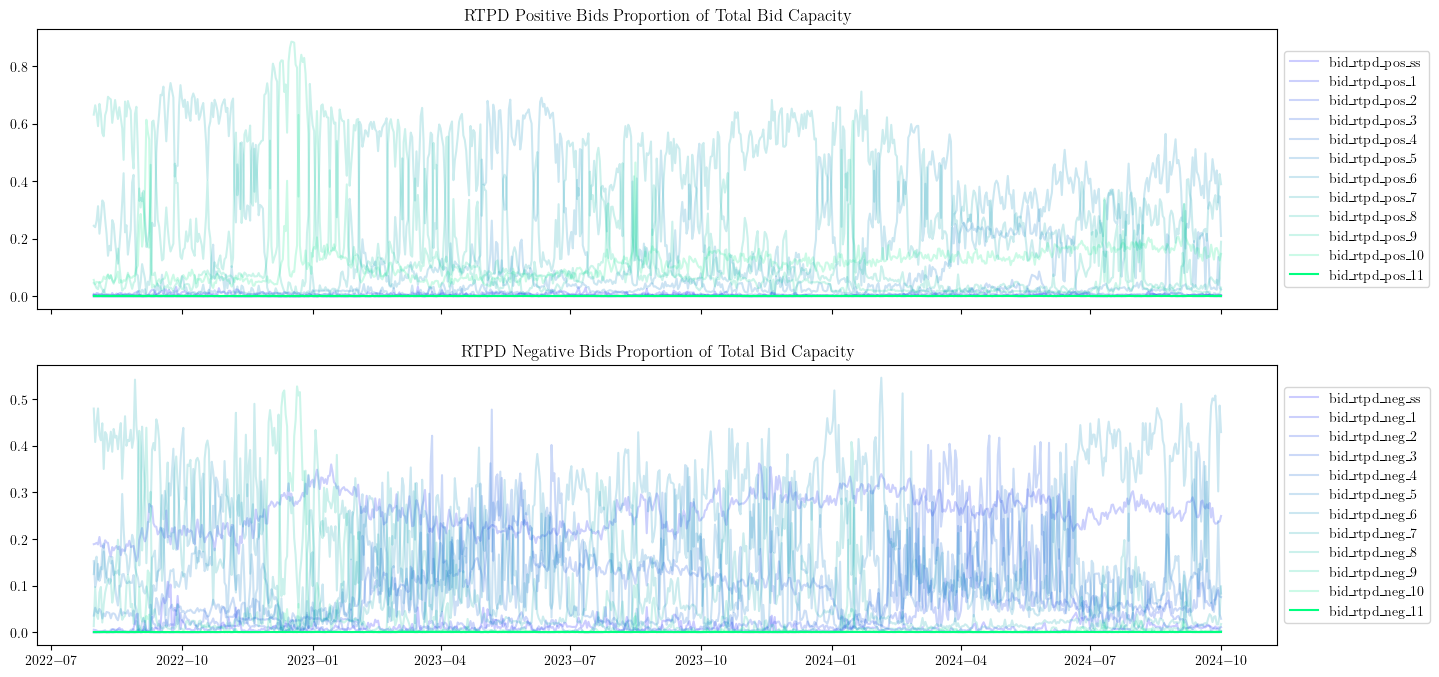

In [38]:
# plot rtpd
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# set interest segment... all other segments have lower opacities
interest_segment = "11"

# Get the colormap
cmap = plt.get_cmap("winter")
colors = cmap(np.linspace(0, 1, len([col for col in bid_columns if "rtpd_pos" in col])))

# Plot rtpd_pos_x proportions with lowered opacity for non-interest segments
for i, col in enumerate([col for col in bid_columns if "rtpd_pos" in col]):
    if interest_segment in col:
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_pos_tot"],
            label=col,
            color=colors[i],
        )
    else:
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_pos_tot"],
            label=col,
            color=colors[i],
            alpha=0.2,
        )
axs[0].set_title("RTPD Positive Bids Proportion of Total Bid Capacity")

# Plot rtpd_neg_x proportions with lowered opacity for non-interest segments
for i, col in enumerate([col for col in bid_columns if "rtpd_neg" in col]):
    if interest_segment in col:
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_neg_tot"],
            label=col,
            color=colors[i],
        )
    else:
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_neg_tot"],
            label=col,
            color=colors[i],
            alpha=0.2,
        )
axs[1].set_title("RTPD Negative Bids Proportion of Total Bid Capacity")

# Move the legend off the right side of the plot
axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

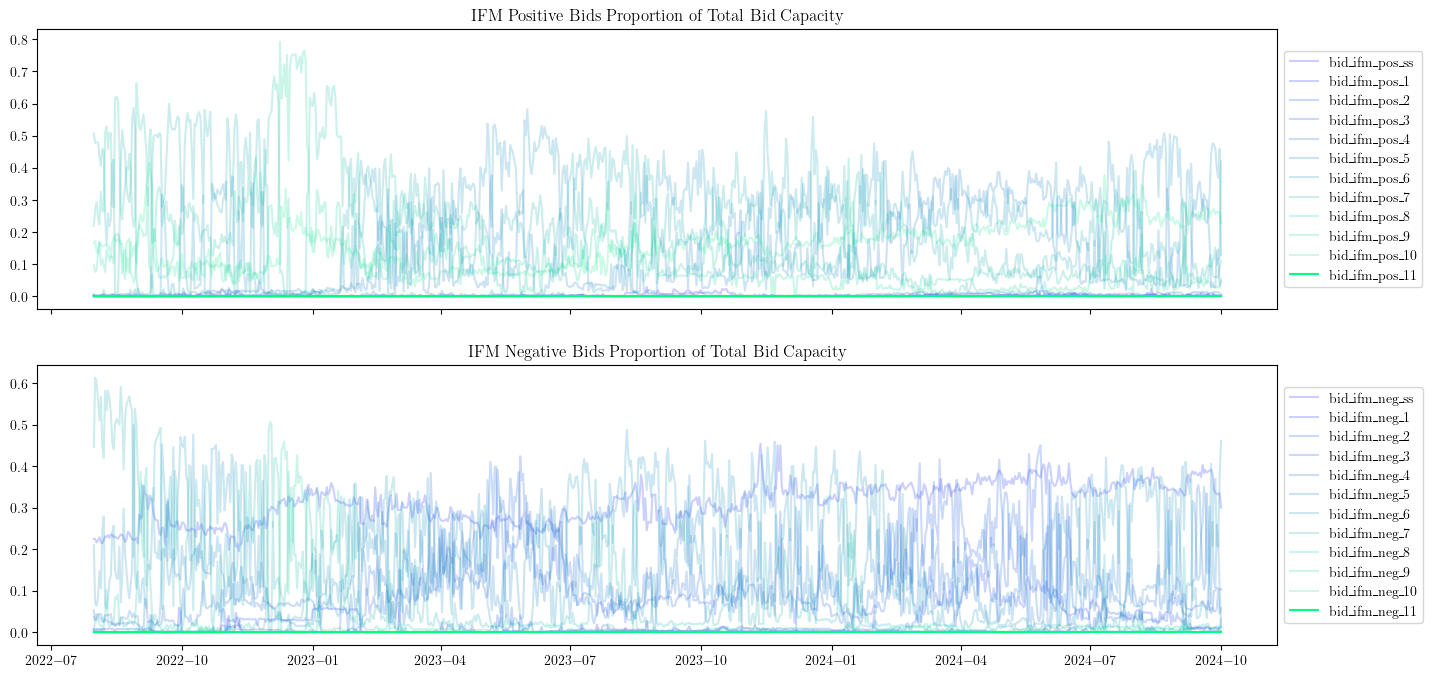

In [39]:
# plot ifm
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Plot ifm_pos_x proportions with lowered opacity for non-interest segments
for i, col in enumerate([col for col in bid_columns if "ifm_pos" in col]):
    if interest_segment in col:
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_pos_tot"],
            label=col,
            color=colors[i],
        )
    else:
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_pos_tot"],
            label=col,
            color=colors[i],
            alpha=0.2,
        )
axs[0].set_title("IFM Positive Bids Proportion of Total Bid Capacity")

# Plot ifm_neg_x proportions with lowered opacity for non-interest segments
for i, col in enumerate([col for col in bid_columns if "ifm_neg" in col]):
    if interest_segment in col:
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_neg_tot"],
            label=col,
            color=colors[i],
        )
    else:
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_neg_tot"],
            label=col,
            color=colors[i],
            alpha=0.2,
        )
axs[1].set_title("IFM Negative Bids Proportion of Total Bid Capacity")

# Move the legend off the right side of the plot
axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

ss


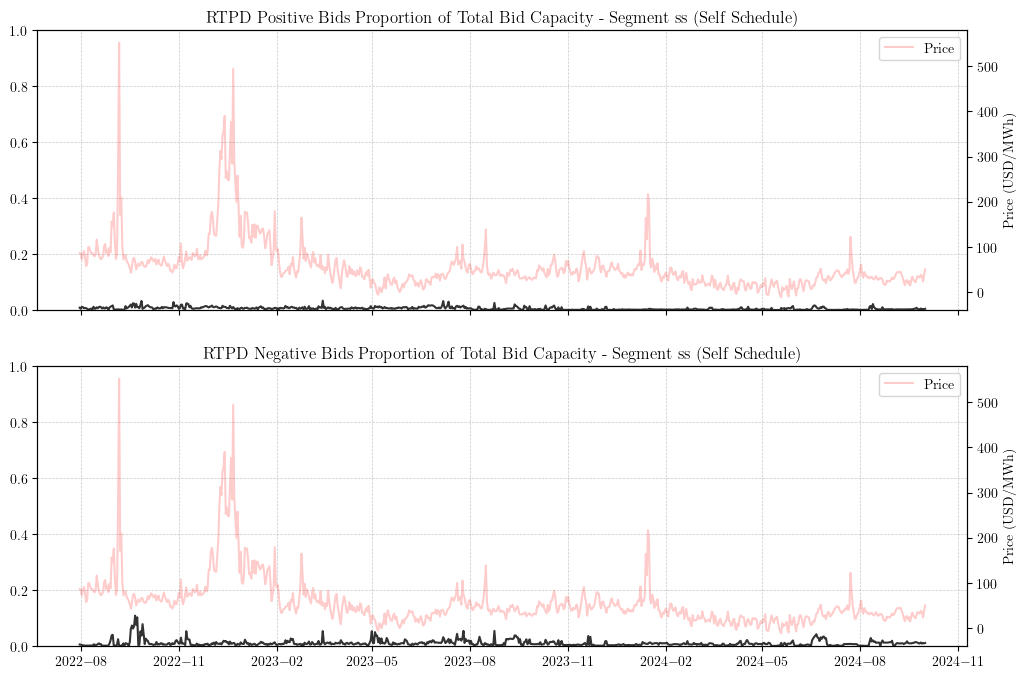

-0.00011355178591170188
1


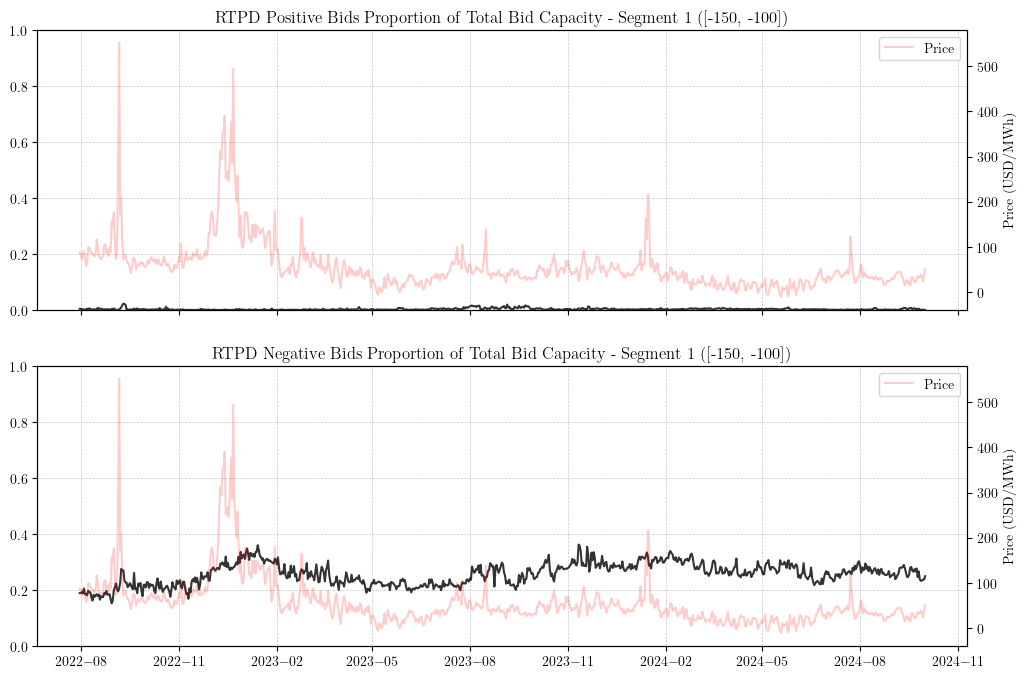

-0.1405205638549434
2


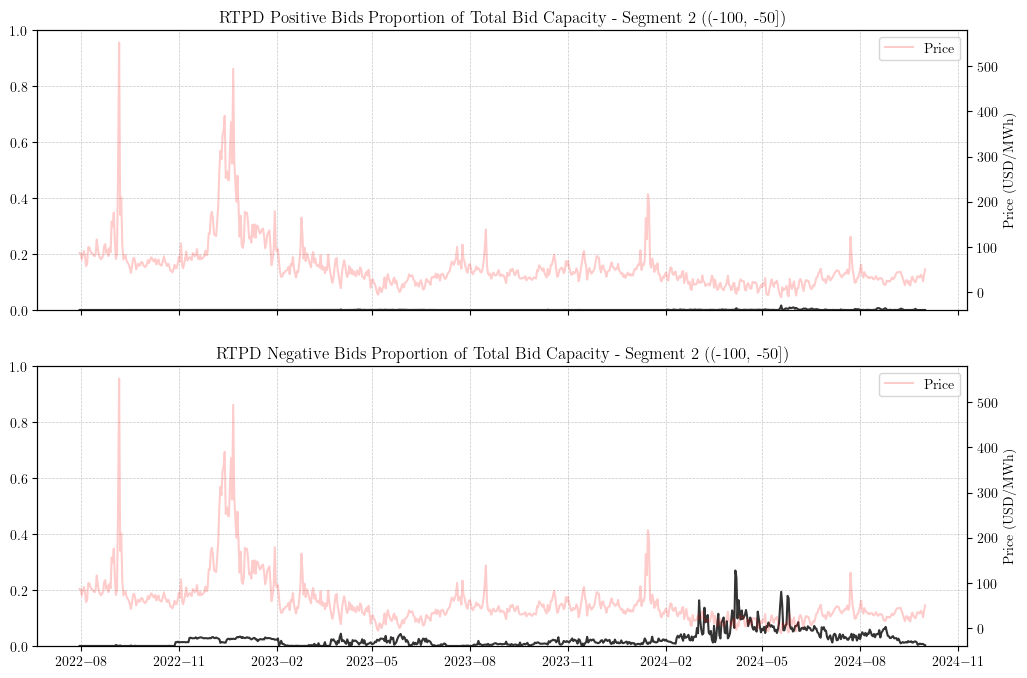

0.0
3


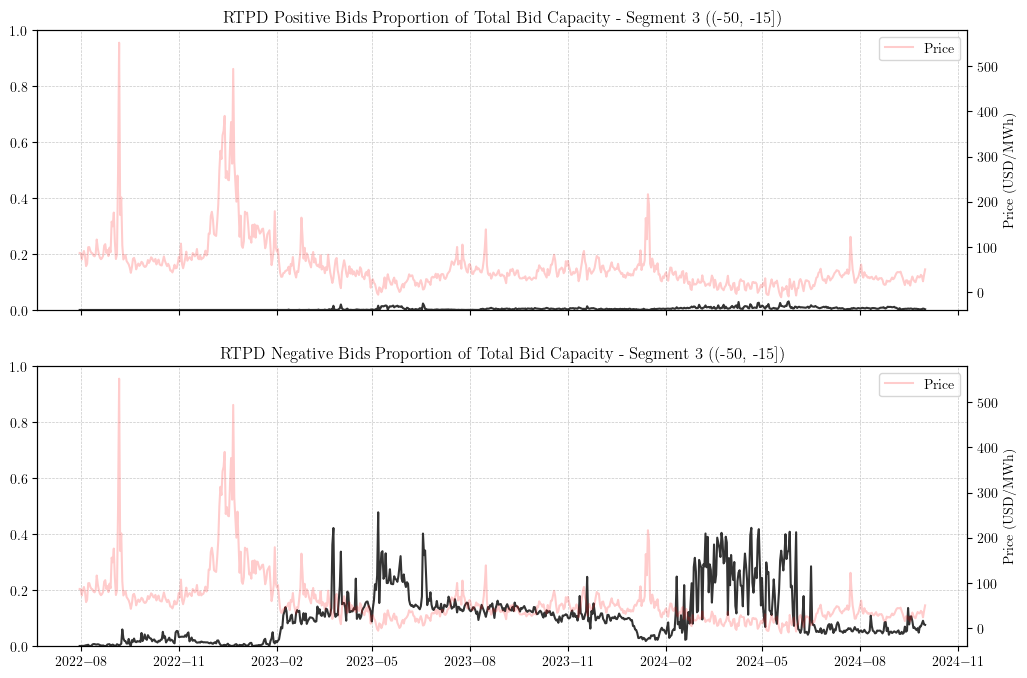

0.0
4


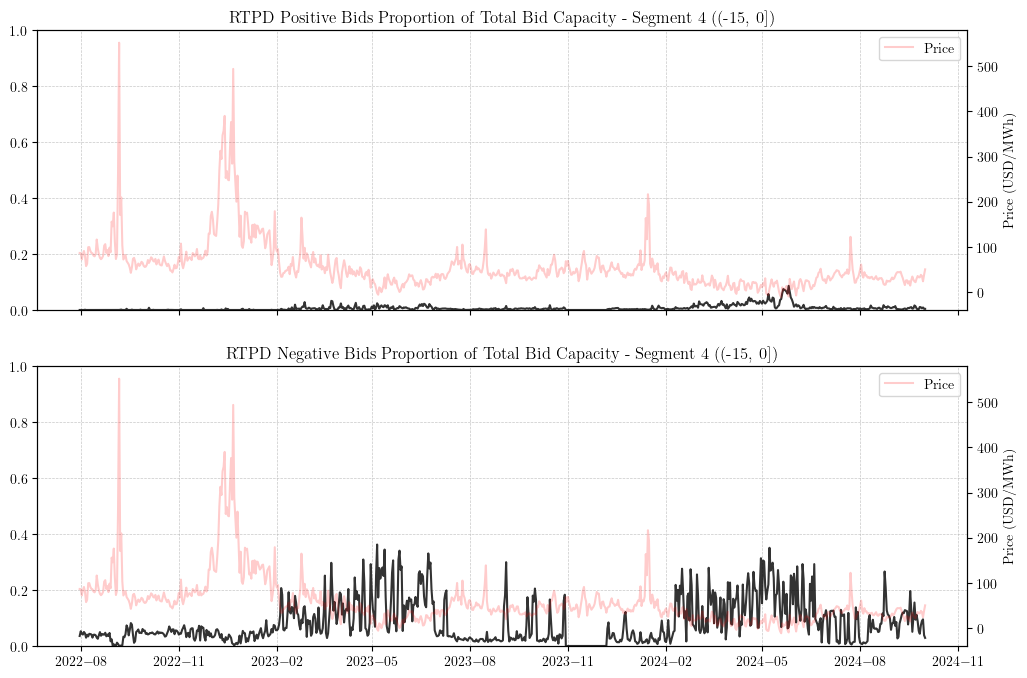

0.0
5


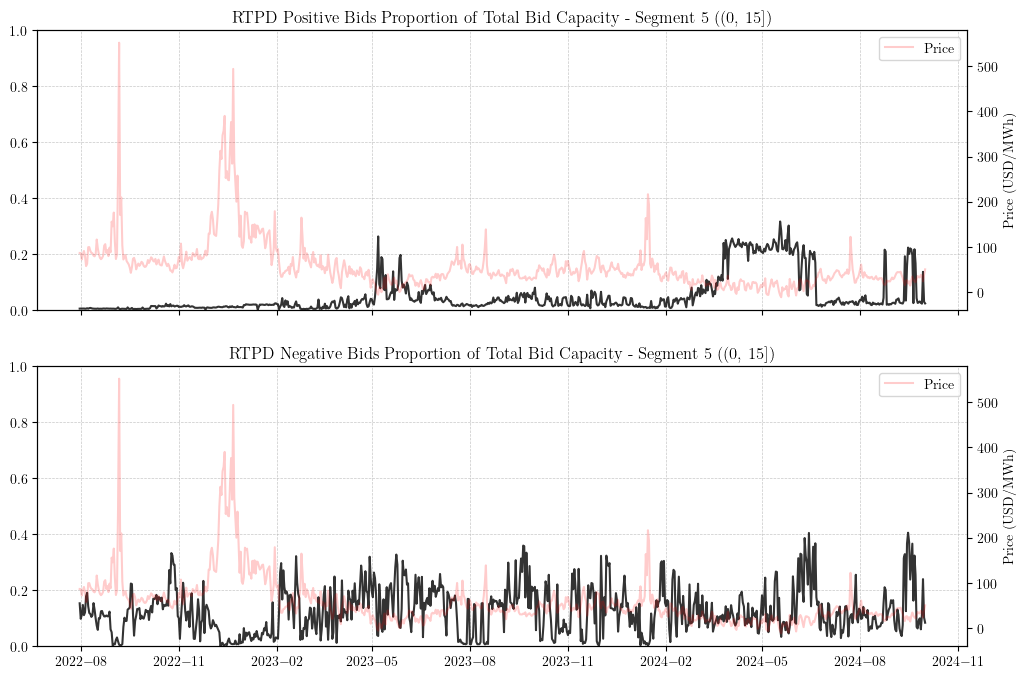

-0.00023496312279750473
6


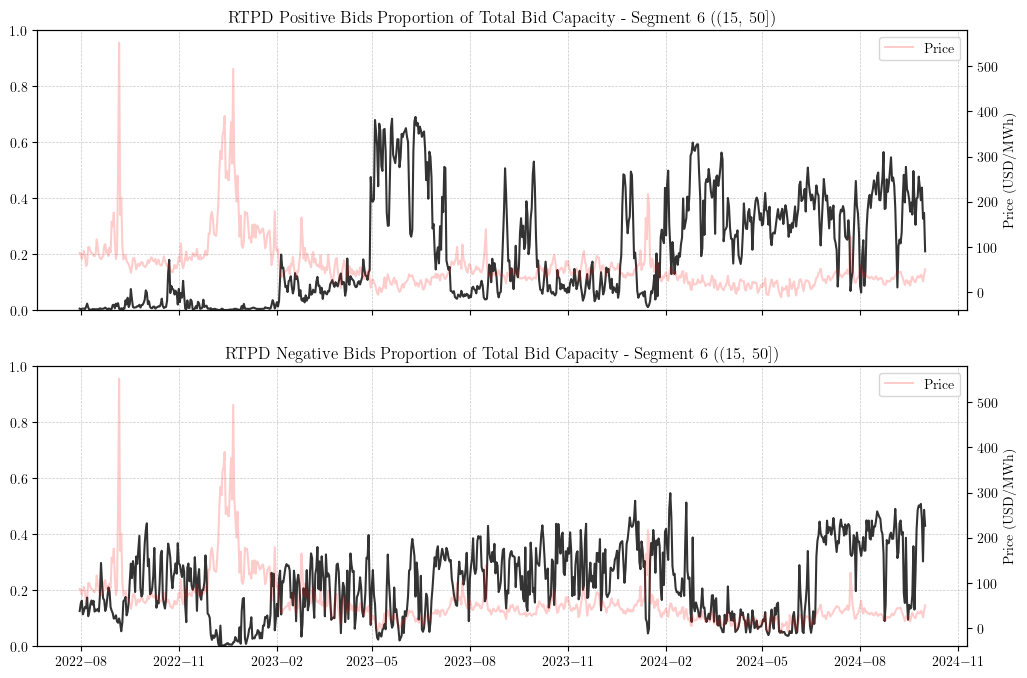

-0.00016383856356761038
7


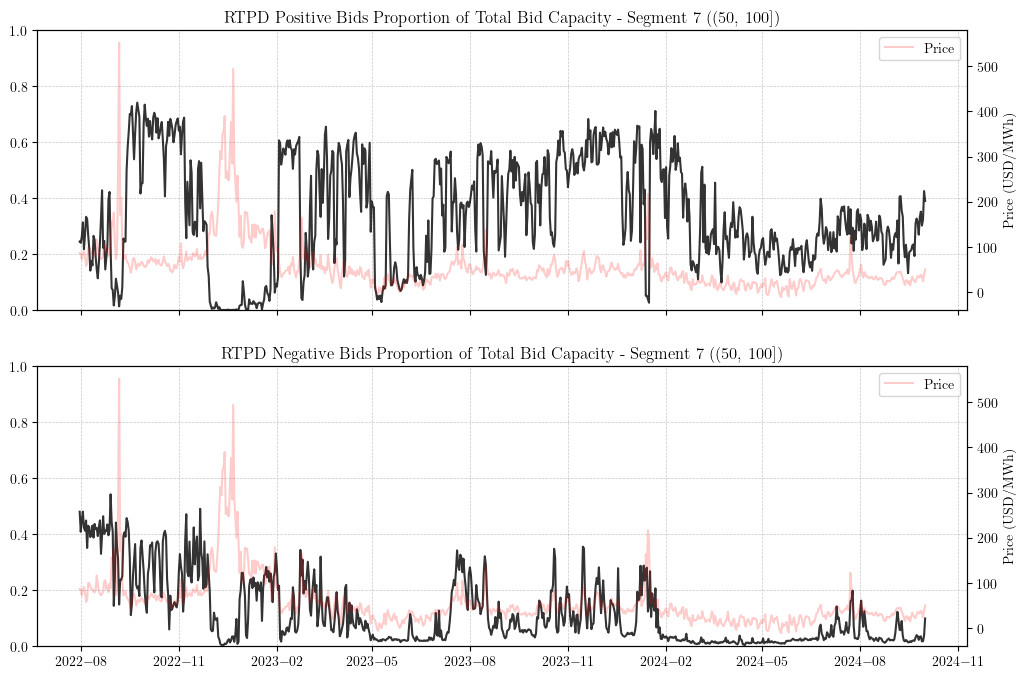

-0.002710089801750762
8


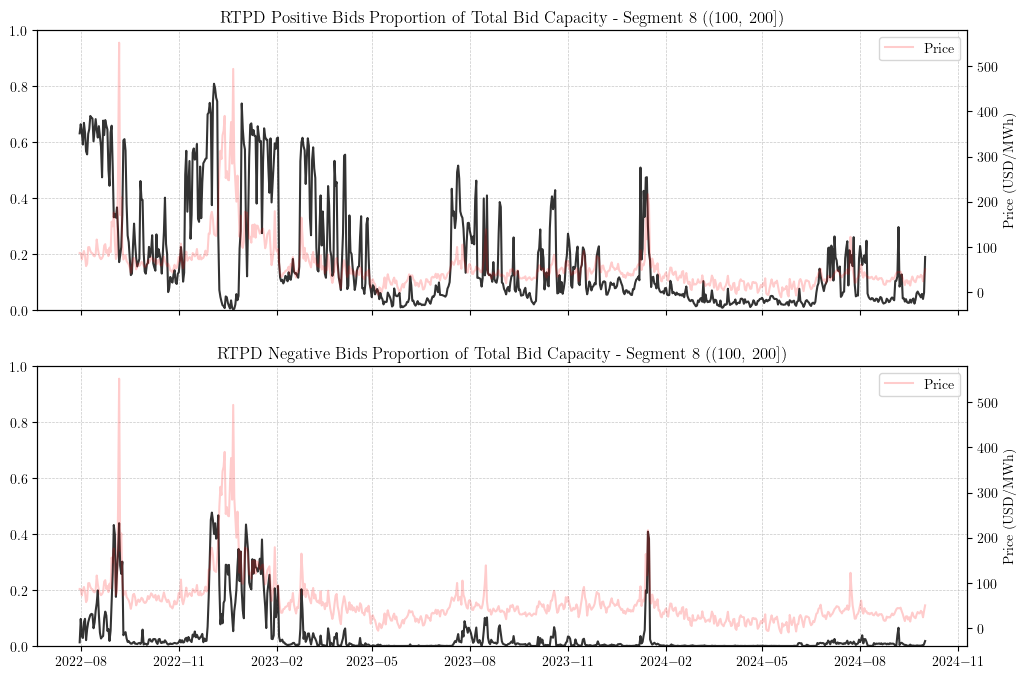

0.0
9


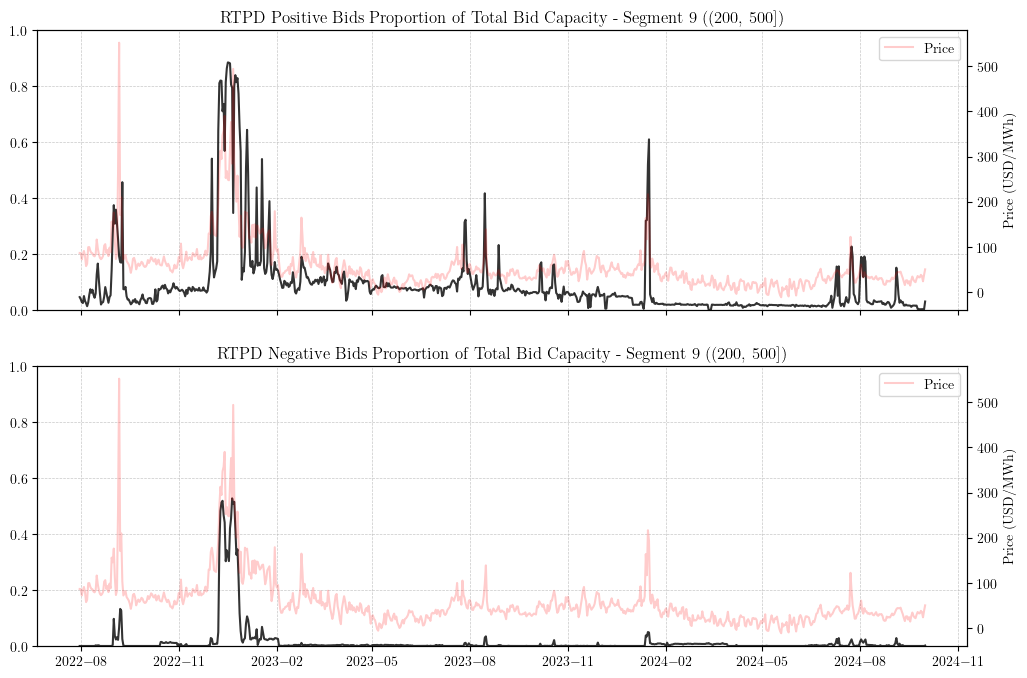

0.0
10


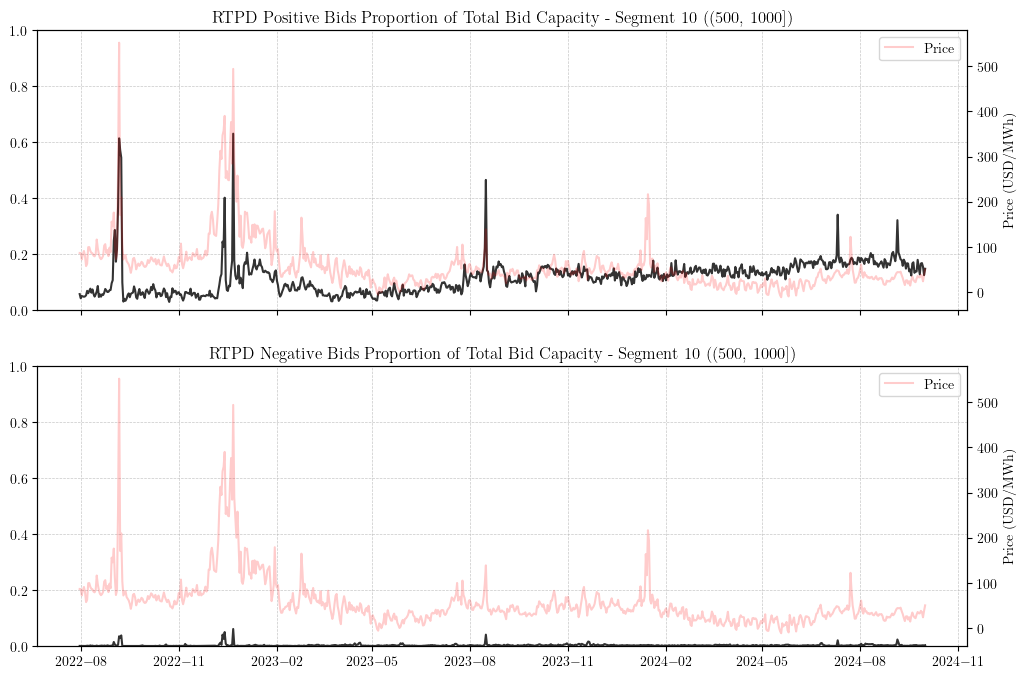

0.0
11


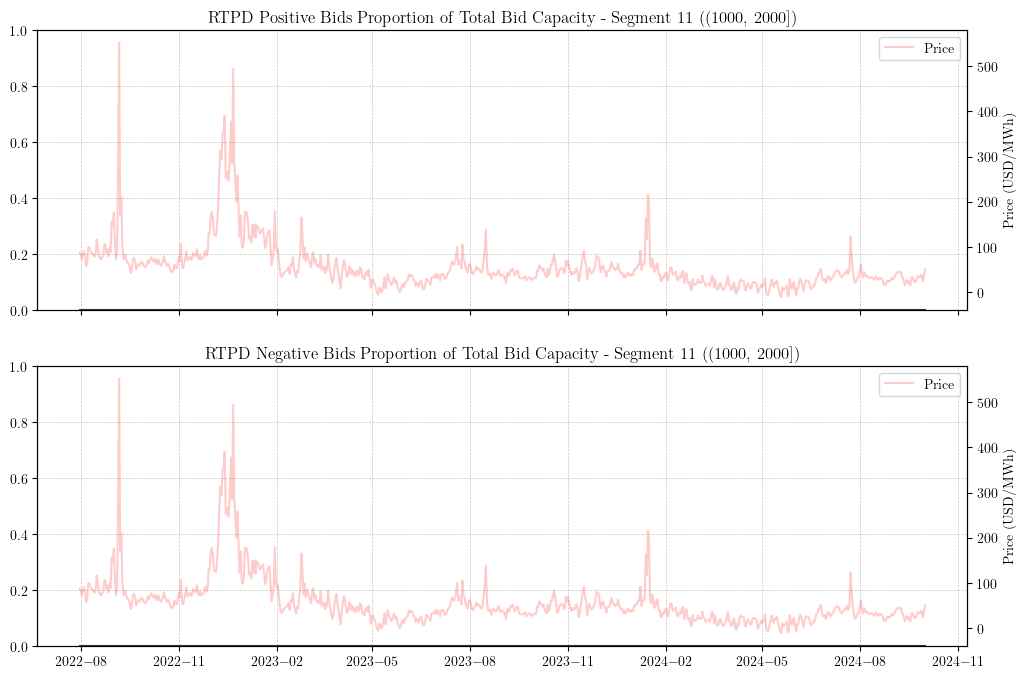

0.0


In [40]:
for interest_segment in ["ss"] + list(str(val + 1) for val in range(11)):
    print(interest_segment)
    # plot rtpd for interest segment
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot rtpd_pos_x proportions for interest segment
    for i, col in enumerate(
        [
            col
            for col in bid_columns
            if "rtpd_pos" in col and col.endswith("_" + interest_segment)
        ]
    ):
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_pos_tot"],
            label=col,
            color="black",
            alpha=0.8,
        )

    axs[0].set_title(
        f"RTPD Positive Bids Proportion of Total Bid Capacity - Segment {interest_segment} ({bid_segments[interest_segment]})"
    )
    axs[0].set_ylim(0, 1)  # Adjust y-axis

    # Create a secondary y-axis for price
    ax2_0 = axs[0].twinx()
    ax2_0.plot(
        df_daily_aggregate.index,
        df_daily_aggregate["price"],
        color="red",
        label="Price",
        alpha=0.2,
    )
    ax2_0.set_ylabel("Price (USD/MWh)")
    ax2_0.legend(loc="upper right")

    # Plot rtpd_neg_x proportions for interest segment
    for i, col in enumerate(
        [
            col
            for col in bid_columns
            if "rtpd_neg" in col and col.endswith("_" + interest_segment)
        ]
    ):
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_neg_tot"],
            label=col,
            color="black",
            alpha=0.8,
        )
    axs[1].set_title(
        f"RTPD Negative Bids Proportion of Total Bid Capacity - Segment {interest_segment} ({bid_segments[interest_segment]})"
    )
    axs[1].set_ylim(0, 1)  # Adjust y-axis

    # Create a secondary y-axis for price
    ax2_1 = axs[1].twinx()
    ax2_1.plot(
        df_daily_aggregate.index,
        df_daily_aggregate["price"],
        color="red",
        label="Price",
        alpha=0.2,
    )
    ax2_1.set_ylabel("Price (USD/MWh)")
    ax2_1.legend(loc="upper right")

    # Set grid lines
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    plt.show()
    print(max(df_daily_aggregate[col] / df_daily_aggregate["bid_rtpd_pos_tot"]))

ss


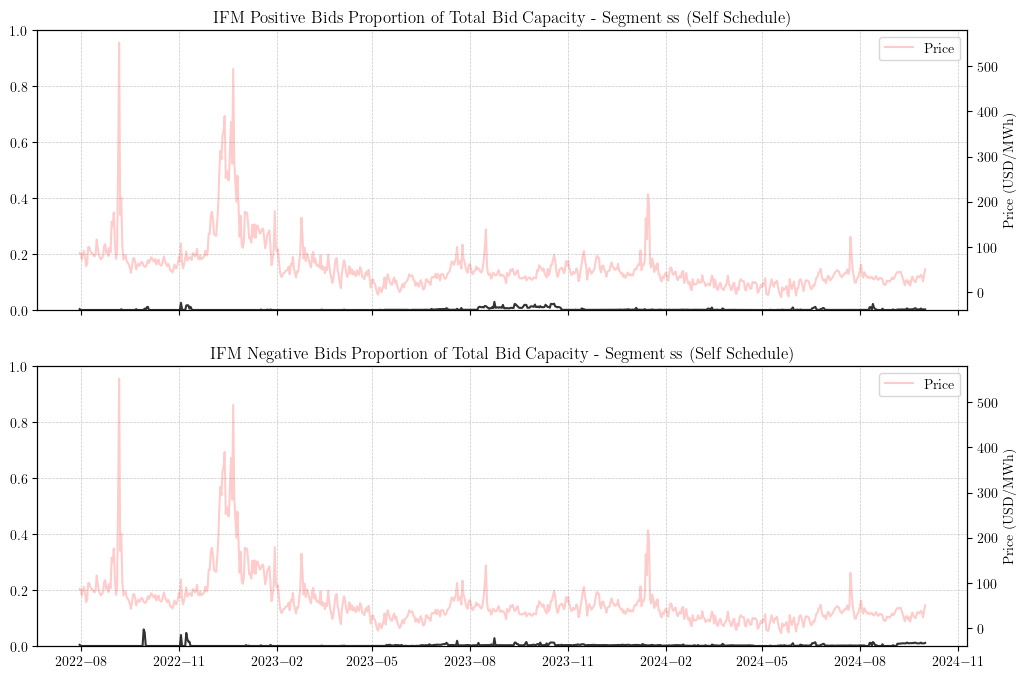

0.0
1


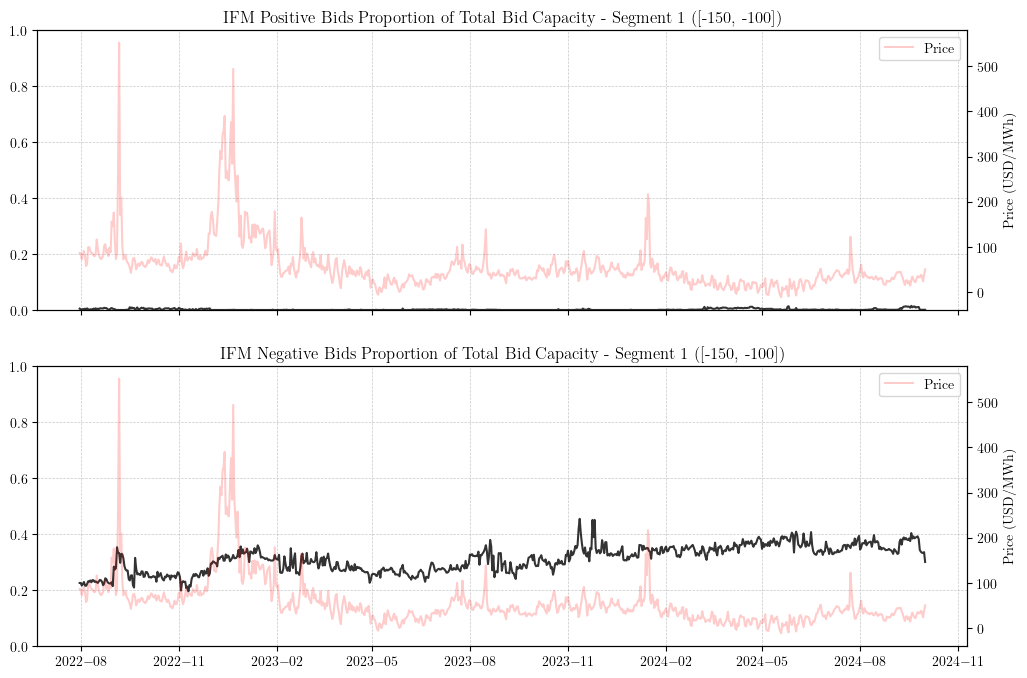

-0.185807462004804
2


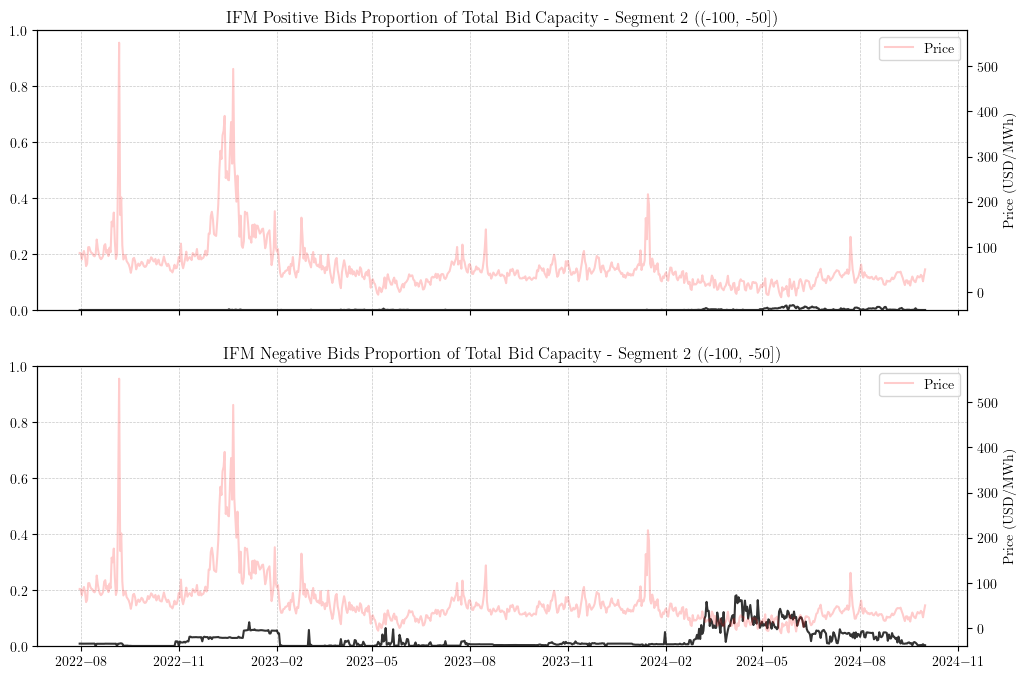

-3.6510762788697904e-06
3


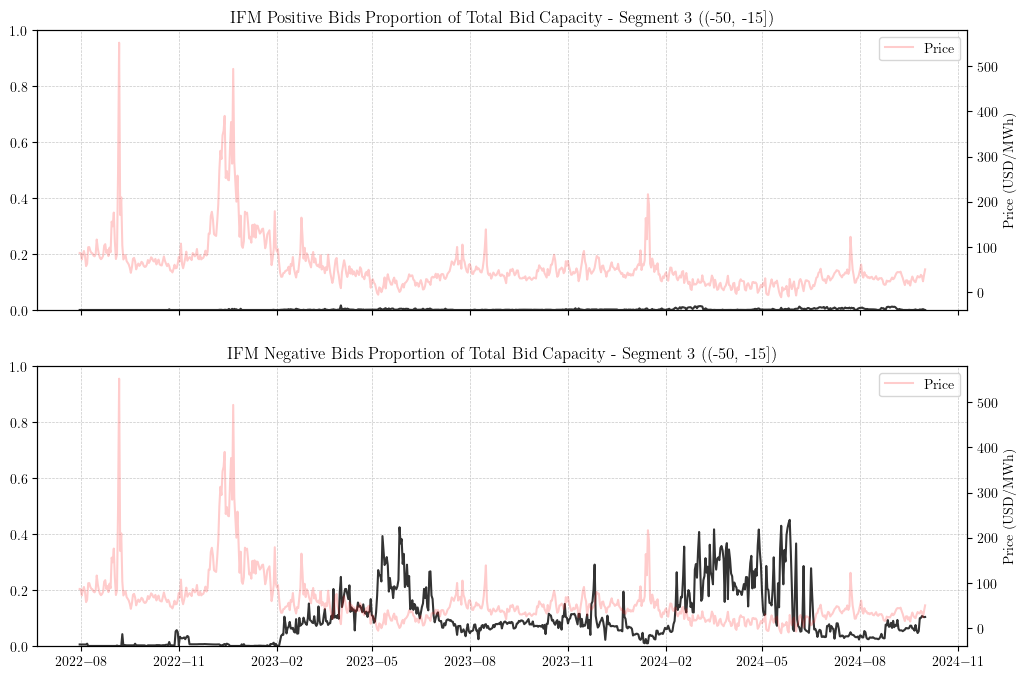

0.0
4


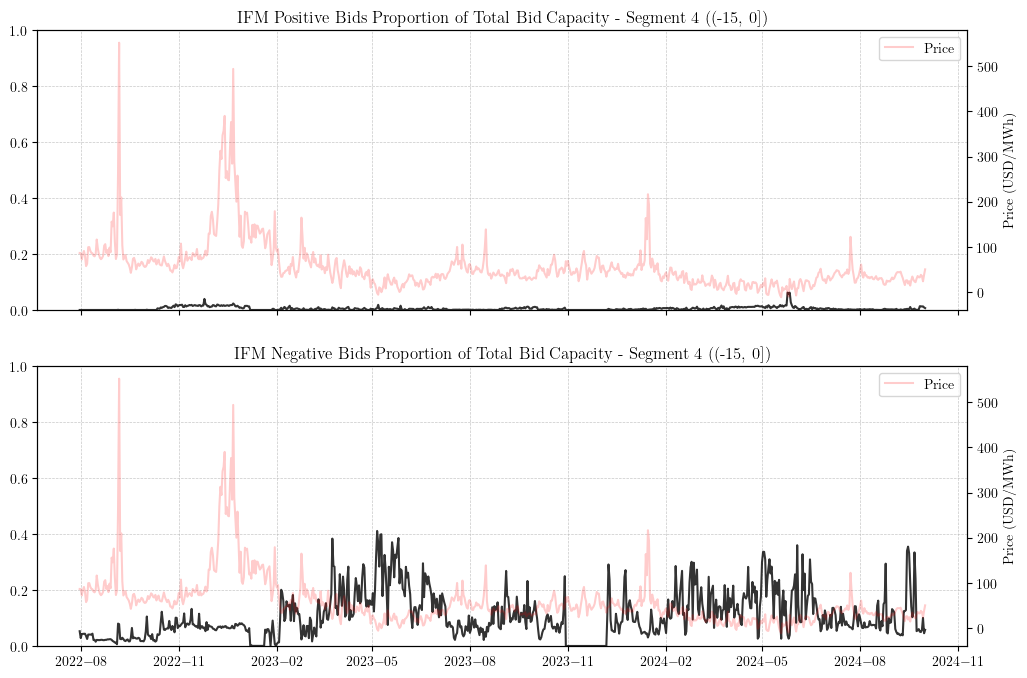

0.0
5


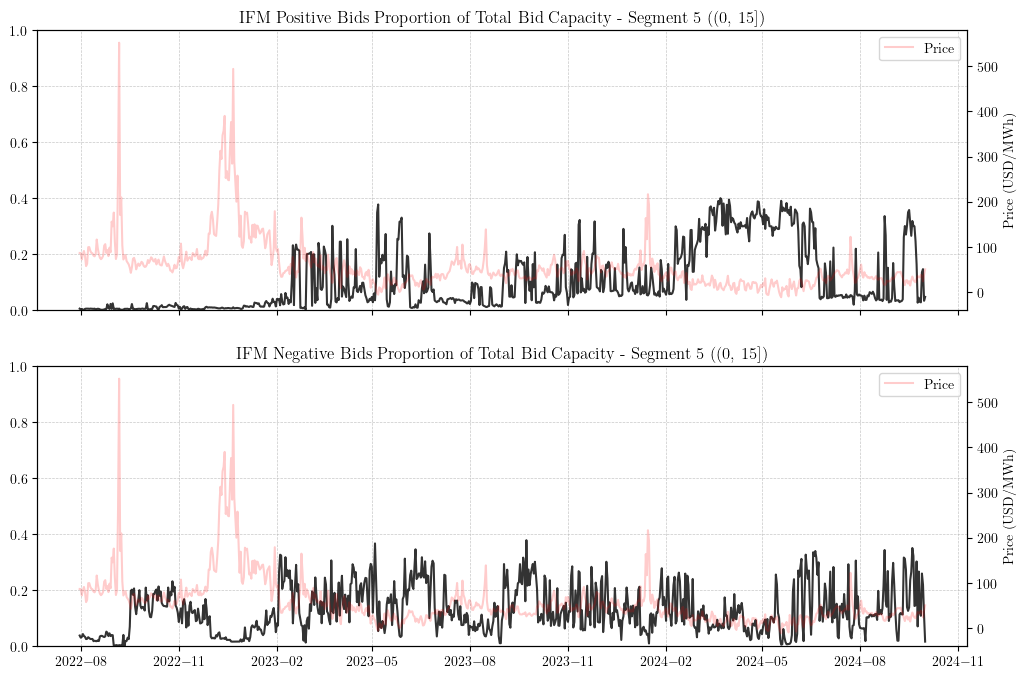

0.0
6


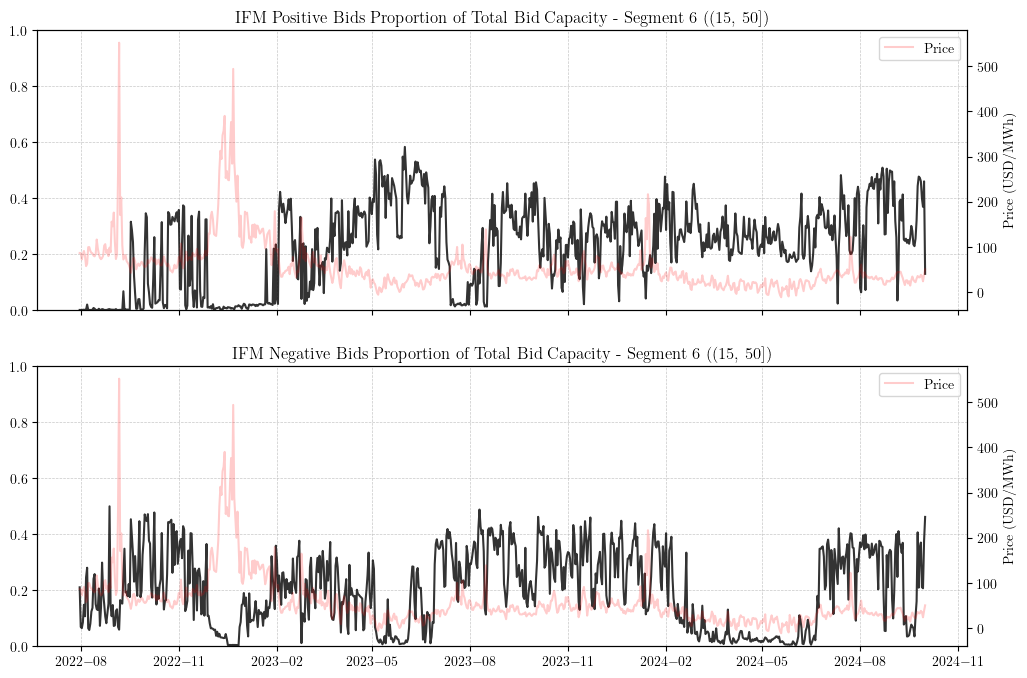

-0.0011755526740509126
7


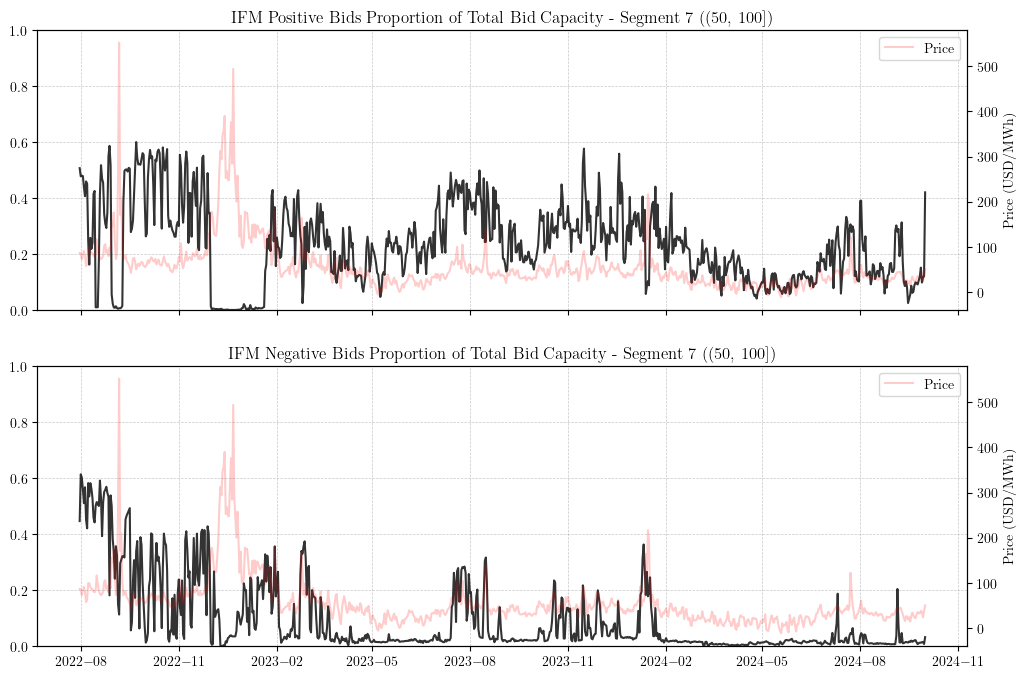

-1.1843867505970491e-05
8


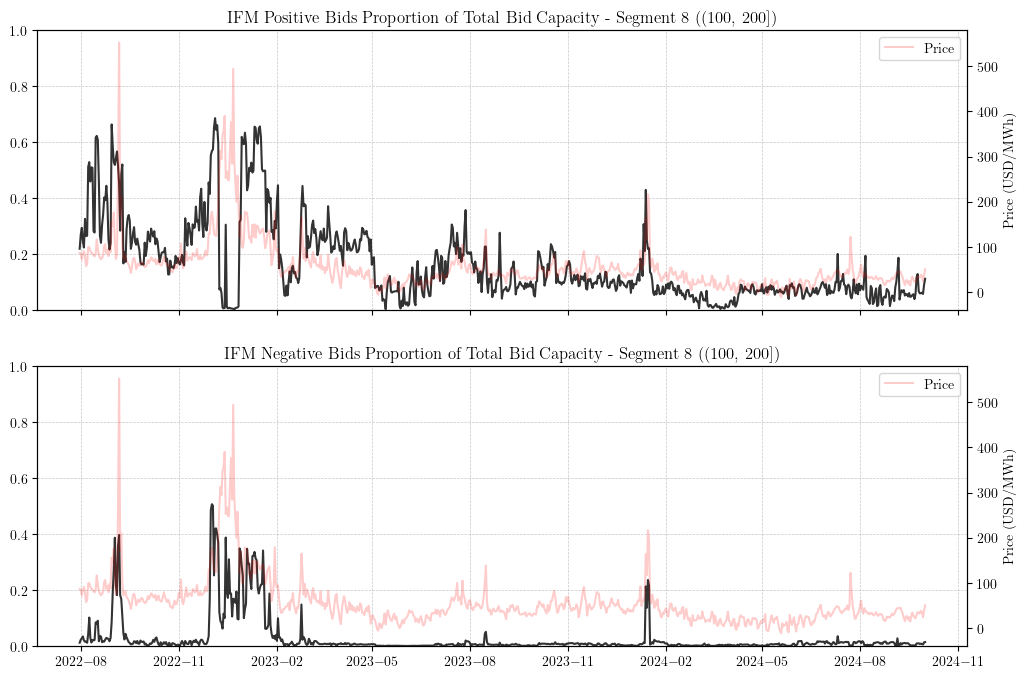

0.0
9


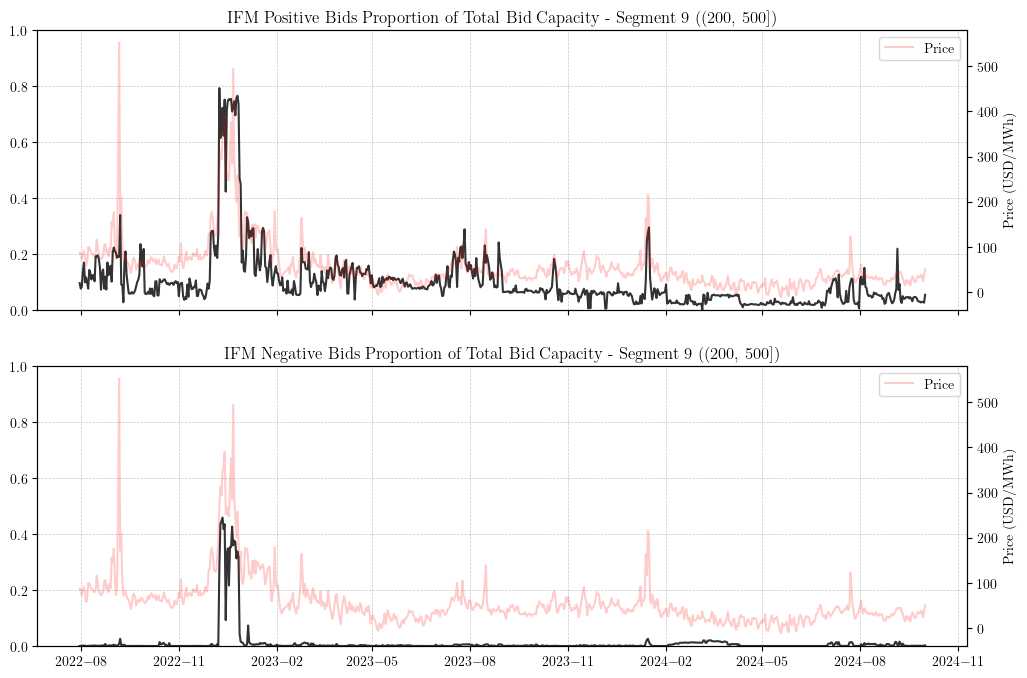

0.0
10


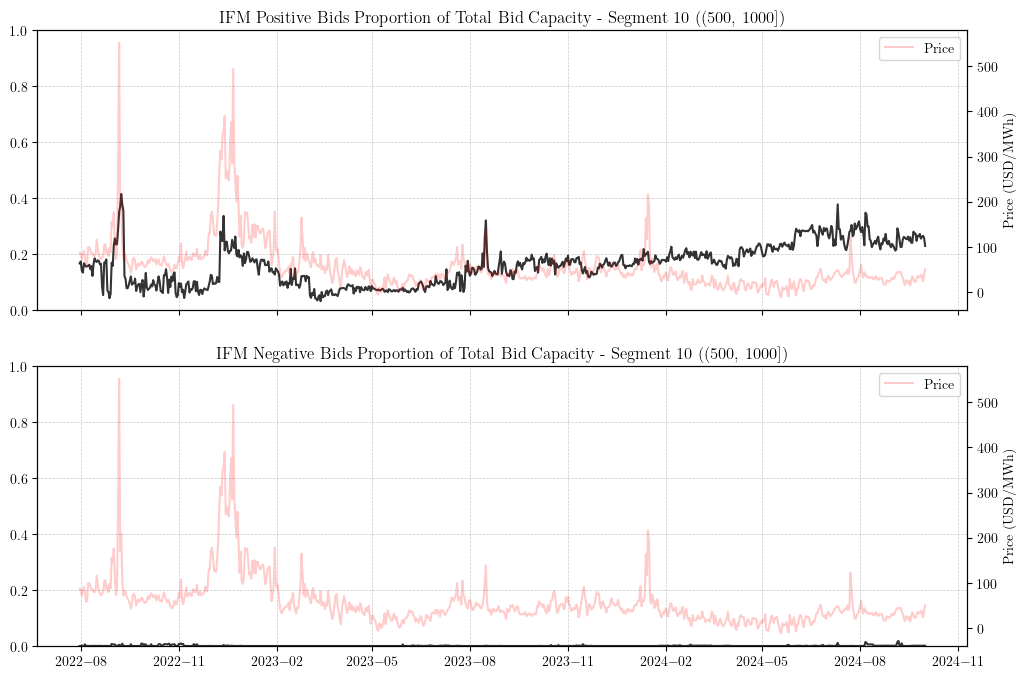

0.0
11


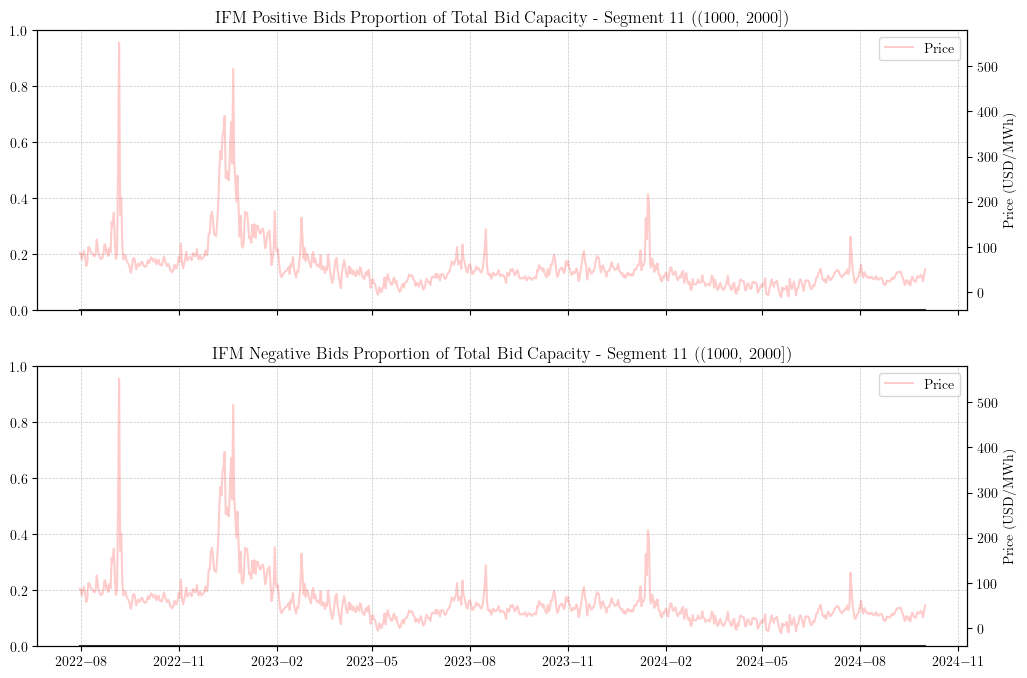

0.0


In [41]:
for interest_segment in ["ss"] + list(str(val + 1) for val in range(11)):
    print(interest_segment)
    # plot ifm for interest segment
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot ifm_pos_x proportions for interest segment
    for i, col in enumerate(
        [
            col
            for col in bid_columns
            if "ifm_pos" in col and col.endswith("_" + interest_segment)
        ]
    ):
        axs[0].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_pos_tot"],
            label=col,
            color="black",
            alpha=0.8,
        )

        # Create a secondary y-axis for price
        ax2_0 = axs[0].twinx()
        ax2_0.plot(
            df_daily_aggregate.index,
            df_daily_aggregate["price"],
            color="red",
            label="Price",
            alpha=0.2,
        )
        ax2_0.set_ylabel("Price (USD/MWh)")
        ax2_0.legend(loc="upper right")
    axs[0].set_title(
        f"IFM Positive Bids Proportion of Total Bid Capacity - Segment {interest_segment} ({bid_segments[interest_segment]})"
    )
    axs[0].set_ylim(0, 1)  # Adjust y-axis

    # Plot ifm_neg_x proportions for interest segment
    for i, col in enumerate(
        [
            col
            for col in bid_columns
            if "ifm_neg" in col and col.endswith("_" + interest_segment)
        ]
    ):
        axs[1].plot(
            df_daily_aggregate.index,
            df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_neg_tot"],
            label=col,
            color="black",
            alpha=0.8,
        )
    axs[1].set_title(
        f"IFM Negative Bids Proportion of Total Bid Capacity - Segment {interest_segment} ({bid_segments[interest_segment]})"
    )

    # Create a secondary y-axis for price
    ax2_1 = axs[1].twinx()
    ax2_1.plot(
        df_daily_aggregate.index,
        df_daily_aggregate["price"],
        color="red",
        label="Price",
        alpha=0.2,
    )
    ax2_1.set_ylabel("Price (USD/MWh)")
    ax2_1.legend(loc="upper right")
    axs[1].set_ylim(0, 1)  # Adjust y-axis

    # Set grid lines
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    plt.show()
    print(max(df_daily_aggregate[col] / df_daily_aggregate["bid_ifm_pos_tot"]))

In [42]:
# Filter columns containing '11'
bid_11_columns = [col for col in df.columns if "11" in col]

# Calculate the sum for each of these columns
bid_11_sums = df[bid_11_columns].sum()

# Print the sums
print(bid_11_sums)

bid_ifm_pos_11     0.0
bid_ifm_neg_11     0.0
bid_rtpd_pos_11    0.0
bid_rtpd_neg_11    0.0
dtype: float64


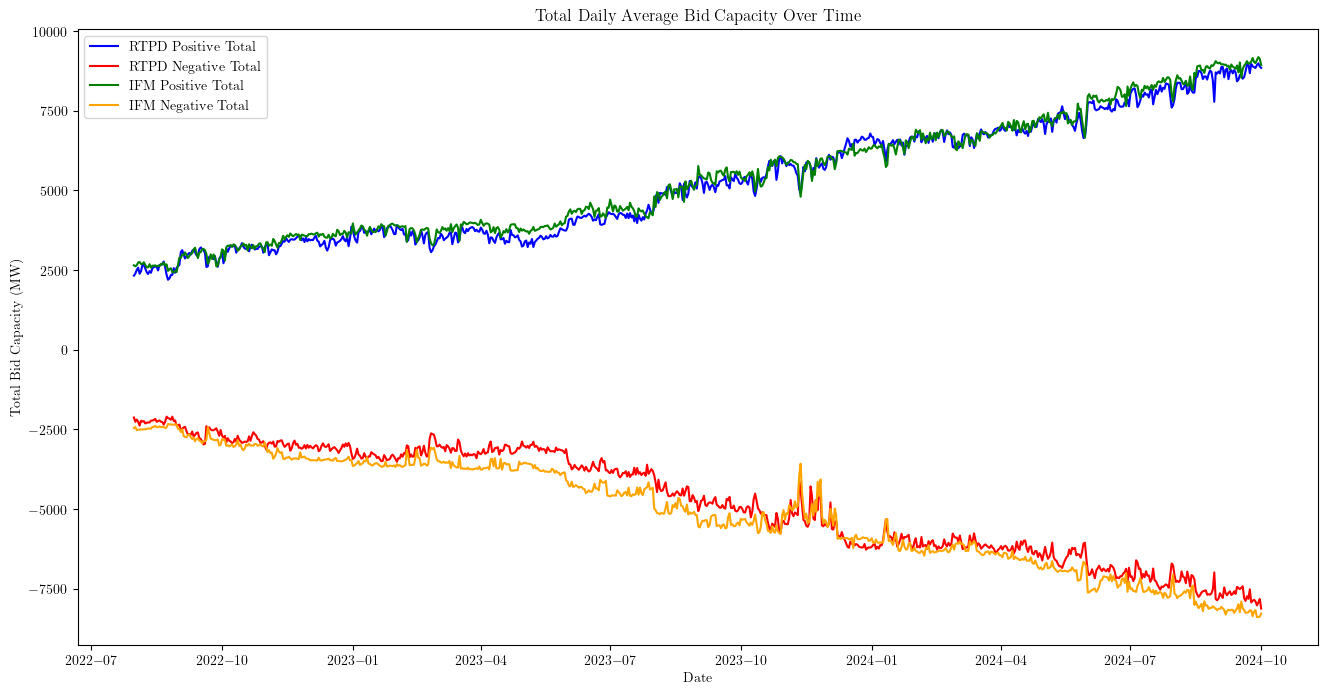

In [43]:
# Plot total bid capacity over time for both positive and negative RTPD and IFM bids
fig, ax = plt.subplots(figsize=(16, 8))

# Plot RTPD positive and negative total bid capacity
ax.plot(
    df_daily_aggregate.index,
    df_daily_aggregate["bid_rtpd_pos_tot"],
    label="RTPD Positive Total",
    color="blue",
)
ax.plot(
    df_daily_aggregate.index,
    df_daily_aggregate["bid_rtpd_neg_tot"],
    label="RTPD Negative Total",
    color="red",
)

# Plot IFM positive and negative total bid capacity
ax.plot(
    df_daily_aggregate.index,
    df_daily_aggregate["bid_ifm_pos_tot"],
    label="IFM Positive Total",
    color="green",
)
ax.plot(
    df_daily_aggregate.index,
    df_daily_aggregate["bid_ifm_neg_tot"],
    label="IFM Negative Total",
    color="orange",
)

# Set title and labels
ax.set_title("Total Daily Average Bid Capacity Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Total Bid Capacity (MW)")

# Add legend
ax.legend(loc="upper left")

plt.show()

In [44]:
print(
    df_daily_aggregate["bid_ifm_pos_tot"][0], df_daily_aggregate["bid_ifm_pos_tot"][-1]
)

2652.240416666667 8935.8875


C:\Users\Astro\AppData\Local\Temp\ipykernel_29716\3844608432.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_daily_aggregate["bid_ifm_pos_tot"][0], df_daily_aggregate["bid_ifm_pos_tot"][-1]


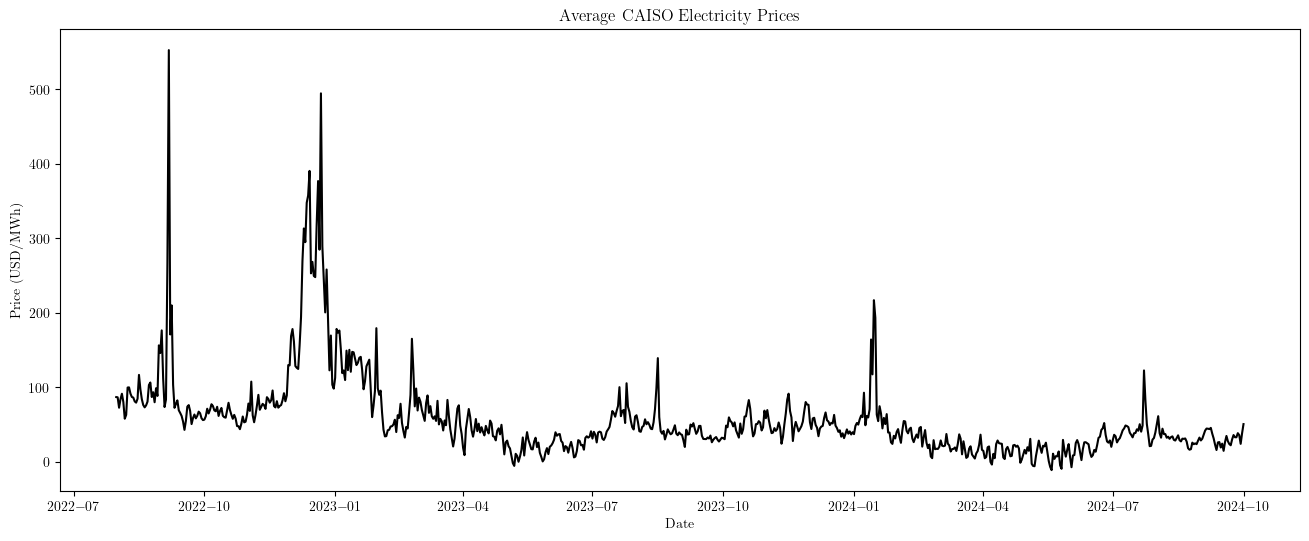

In [45]:
# Plot total bid capacity over time for both positive and negative RTPD and IFM bids
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(
    df_daily_aggregate.index,
    df_daily_aggregate["price"],
    label="Average CAISO Price",
    color="black",
)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD/MWh)")
ax.set_title("Average CAISO Electricity Prices")

plt.show()

In [46]:
# identify dates, price spikes, and average prices
start_filter_date = pd.Timestamp("2024-07-01")
end_filter_date = pd.Timestamp("2024-10-01")

df_filtered = df_daily_aggregate[
    (df_daily_aggregate.index > start_filter_date)
    & (df_daily_aggregate.index < end_filter_date)
]
print(df_filtered.index[np.argmax(df_filtered.price)])
print(df_filtered.price[np.argmax(df_filtered.price)])
print(np.mean(df_filtered.price))

2024-07-23 00:00:00
122.47371691071429
34.86647530595227


C:\Users\Astro\AppData\Local\Temp\ipykernel_29716\3339174790.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_filtered.price[np.argmax(df_filtered.price)])


In [47]:
def plot_bid_distribution(
    start_date: str = None,
    end_date: str = None,
):
    if end_date == None:
        # Filter the data for the start_date
        df_interest_date = df_daily_aggregate.loc[pd.Timestamp(start_date)]
        date_interest_string = start_date
    else:
        # Filter the data for the date range
        df_interest_date = df_daily_aggregate.loc[
            pd.Timestamp(start_date) : pd.Timestamp(end_date)
        ]
        date_interest_string = f"{start_date} to {end_date}"

        df_interest_date = df_interest_date.mean()

    # Extract the relevant columns and align segments by suffix
    suffixes = ["ss"] + [str(i) for i in range(1, 12)]
    x_markers = [bid_segments[s] for s in suffixes]

    rtpd_pos_columns = [f"bid_rtpd_pos_{suffix}" for suffix in suffixes]
    rtpd_neg_columns = [f"bid_rtpd_neg_{suffix}" for suffix in suffixes]
    ifm_pos_columns = [f"bid_ifm_pos_{suffix}" for suffix in suffixes]
    ifm_neg_columns = [f"bid_ifm_neg_{suffix}" for suffix in suffixes]

    max_y_lim = max(
        max(df_interest_date[rtpd_pos_columns] / df_interest_date["bid_rtpd_pos_tot"]),
        max(df_interest_date[ifm_pos_columns] / df_interest_date["bid_ifm_pos_tot"]),
        max(df_interest_date[rtpd_neg_columns] / df_interest_date["bid_rtpd_neg_tot"]),
        max(df_interest_date[ifm_neg_columns] / df_interest_date["bid_ifm_neg_tot"]),
    )
    max_y_lim = math.ceil(max_y_lim * 10) / 10

    # Create a 2x2 figure
    fig, axs = plt.subplots(
        2, 2, figsize=(12, 8), sharex=True, sharey=False, gridspec_kw={"hspace": 0}
    )

    # Plot the stacked distribution for RTPD positive bids
    (df_interest_date[rtpd_pos_columns] / df_interest_date["bid_rtpd_pos_tot"]).plot(
        kind="bar", stacked=True, ax=axs[0, 0], width=1.0
    )
    axs[0, 0].set_xlabel("Bid Segments")
    axs[0, 0].set_ylabel("Positive Bid Seg. Prop.")
    axs[0, 0].set_ylim((0, max_y_lim))
    axs[0, 0].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)
    axs[0, 0].grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    # Plot the stacked distribution for IFM positive bids
    (df_interest_date[ifm_pos_columns] / df_interest_date["bid_ifm_pos_tot"]).plot(
        kind="bar", stacked=True, ax=axs[0, 1], width=1.0
    )
    axs[0, 1].set_ylim((0, max_y_lim))
    axs[0, 1].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)
    axs[0, 1].grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    # Plot the stacked distribution for RTPD negative bids
    (df_interest_date[rtpd_neg_columns] / df_interest_date["bid_rtpd_neg_tot"]).plot(
        kind="bar", stacked=True, ax=axs[1, 0], width=1.0
    )
    axs[1, 0].set_xlabel("RTPD Bid Segments")
    axs[1, 0].set_ylabel("Negative Bid Seg. Prop.")
    axs[1, 0].invert_yaxis()
    axs[1, 0].set_ylim((max_y_lim, 0))
    axs[1, 0].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)
    axs[1, 0].grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    # Plot the stacked distribution for IFM negative bids
    (df_interest_date[ifm_neg_columns] / df_interest_date["bid_ifm_neg_tot"]).plot(
        kind="bar", stacked=True, ax=axs[1, 1], width=1.0
    )
    axs[1, 1].set_xlabel("IFM Bid Segments")
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_ylim((max_y_lim, 0))
    axs[1, 1].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)
    axs[1, 1].grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    fig.suptitle(f"RTPD and IFM Bid Segment Composition for {date_interest_string}")
    plt.xticks(np.arange(0, 12), x_markers)

    plt.tight_layout()
    plt.show()

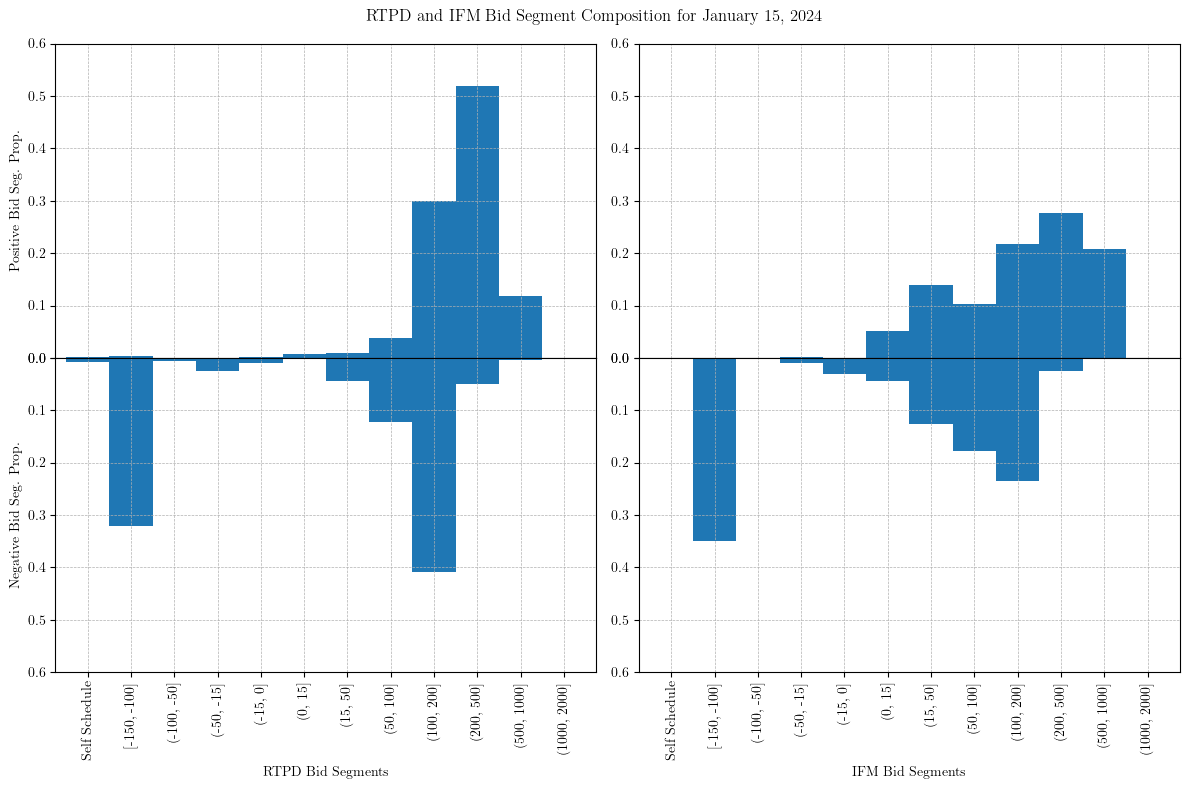

In [48]:
plot_bid_distribution(start_date="January 15, 2024")

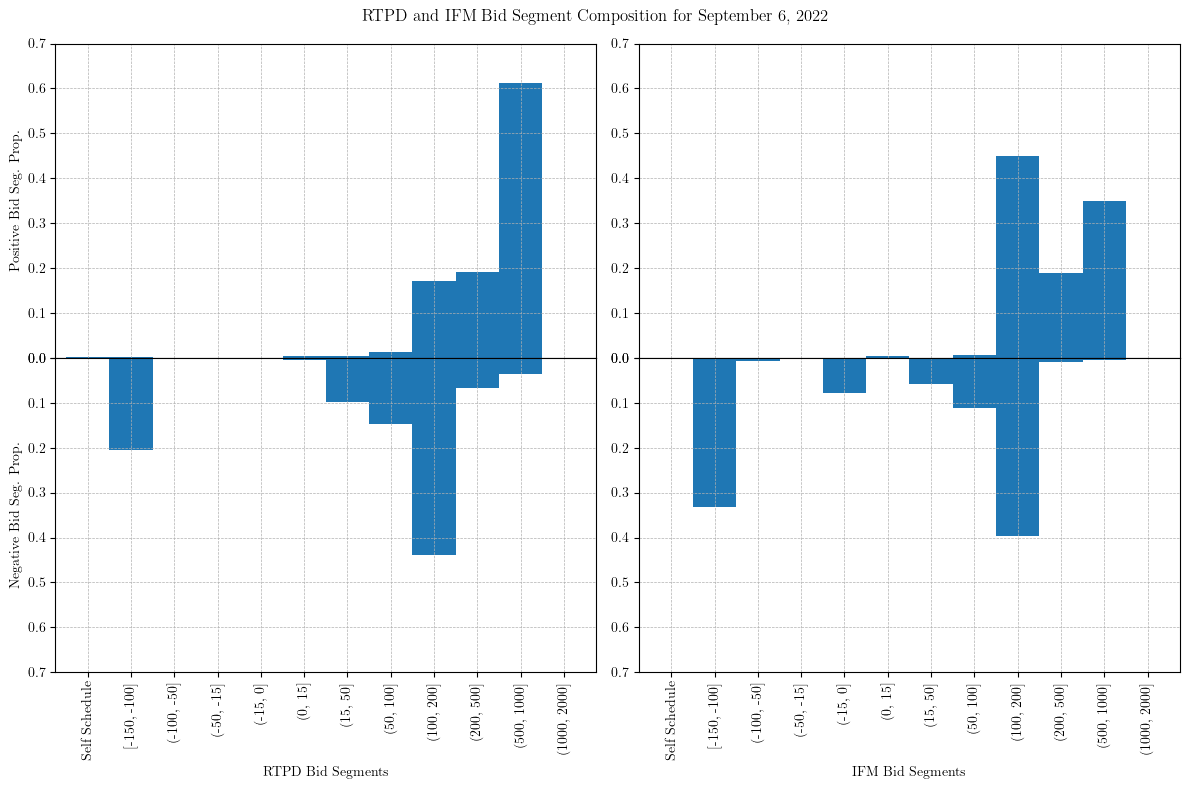

In [49]:
plot_bid_distribution(start_date="September 6, 2022")

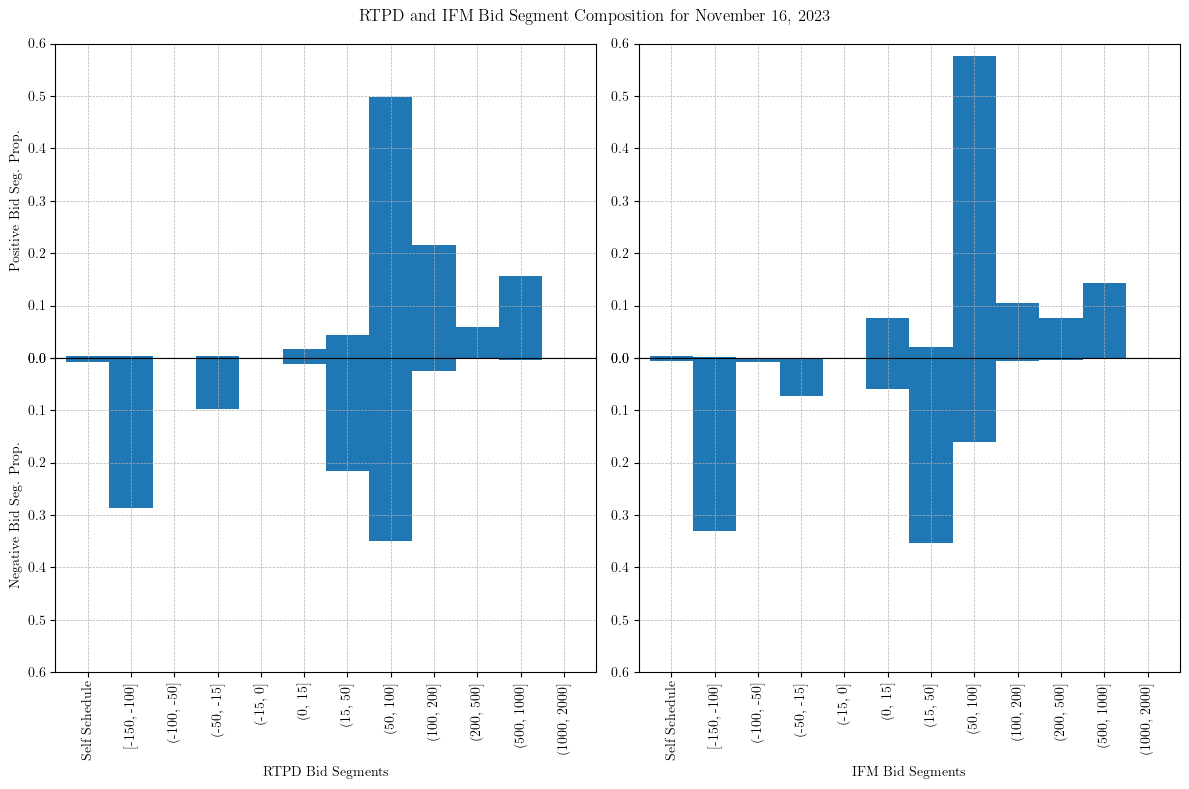

In [50]:
plot_bid_distribution(start_date="November 16, 2023")

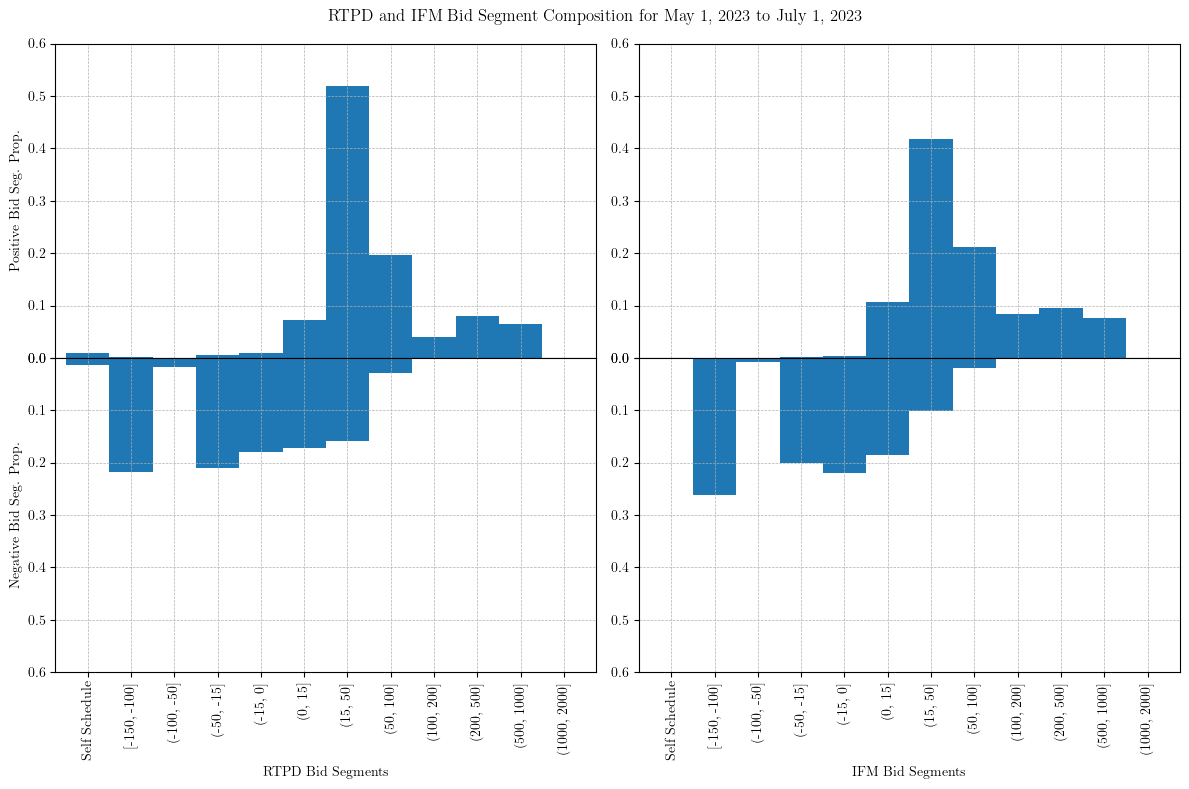

In [51]:
plot_bid_distribution(start_date="May 1, 2023", end_date="July 1, 2023")

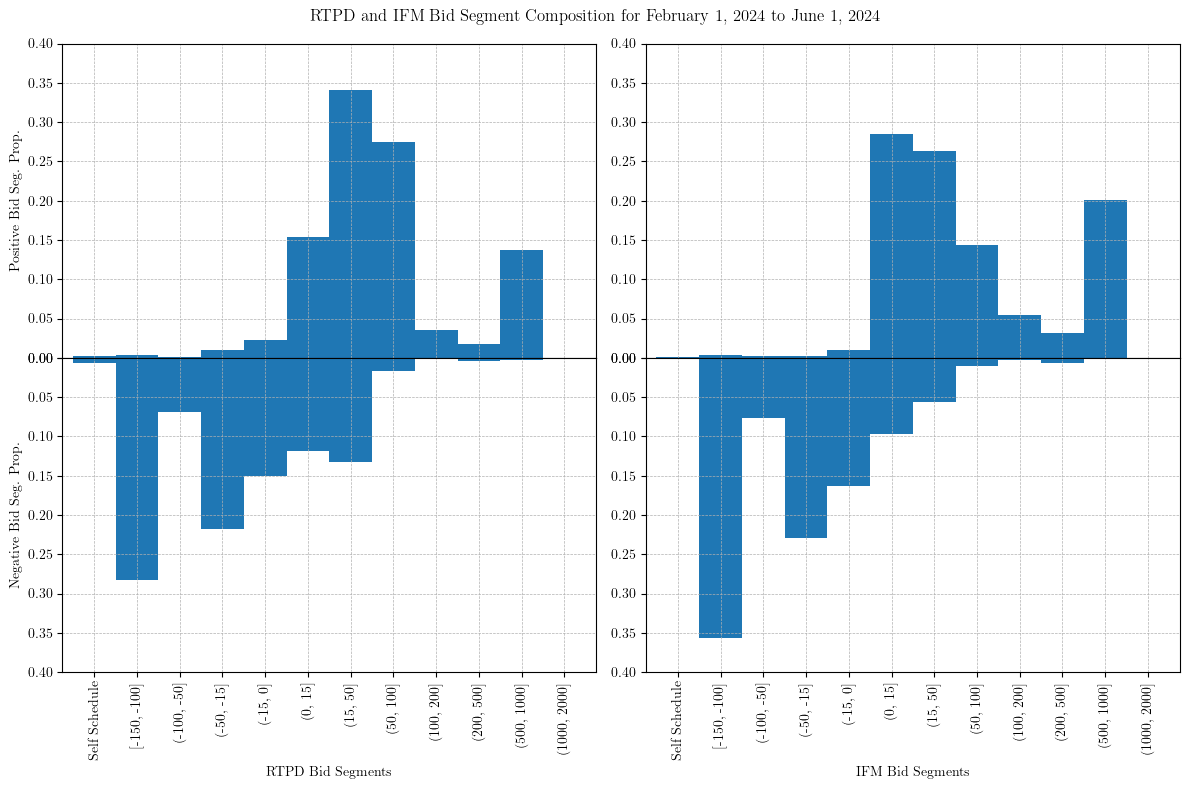

In [52]:
plot_bid_distribution(start_date="February 1, 2024", end_date="June 1, 2024")

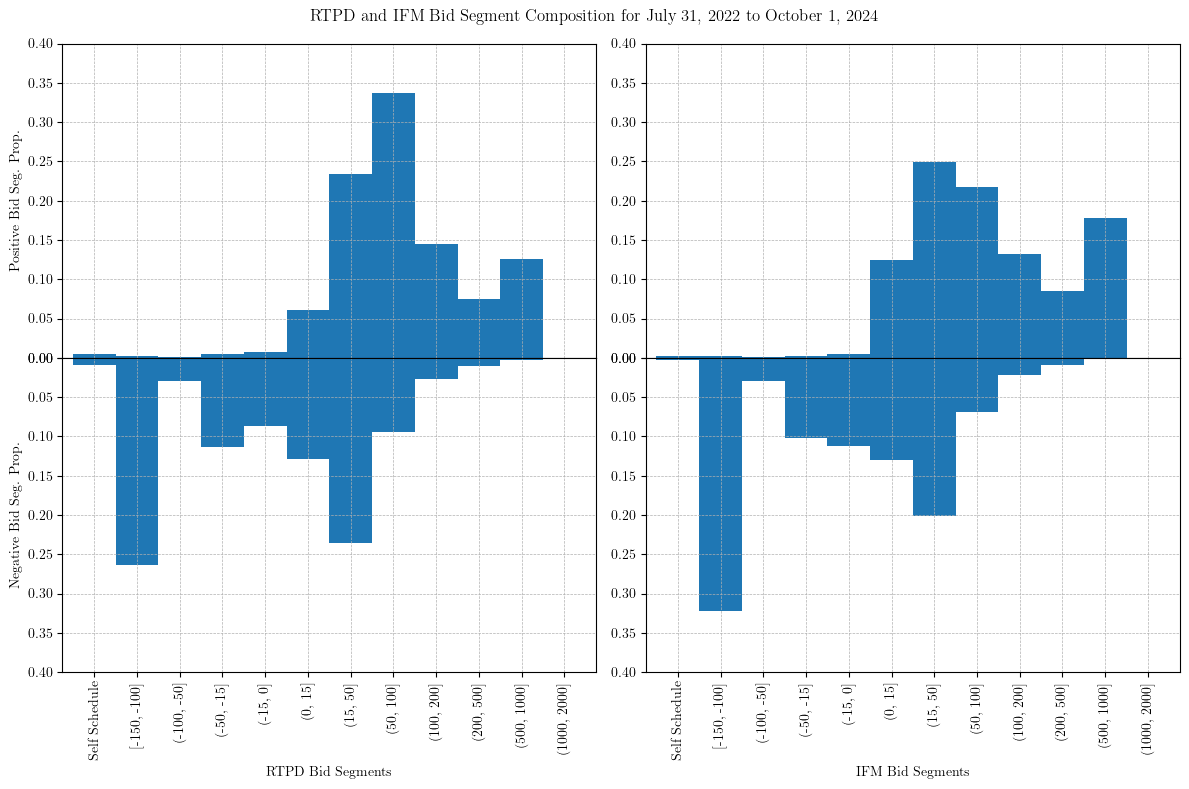

In [53]:
plot_bid_distribution(start_date="July 31, 2022", end_date="October 1, 2024")

In [109]:
bid_segment_edges = [-150, -100, -50, -15, 0, 15, 50, 100, 200, 500, 1000, 2000]
bid_segment_weights = [
    (bid_segment_edges[i] + bid_segment_edges[i + 1]) / 2.0
    for i in range(len(bid_segment_edges) - 1)
]
# bid_segment_weights = [1.] * 11

df_weighted_daily = df_daily_aggregate.copy()
df_weighted_daily["bid_ifm_pos_avg"] = (
    np.abs(df_weighted_daily["bid_ifm_pos_1"]) * bid_segment_weights[0]
    + np.abs(df_weighted_daily["bid_ifm_pos_2"]) * bid_segment_weights[1]
    + np.abs(df_weighted_daily["bid_ifm_pos_3"]) * bid_segment_weights[2]
    + np.abs(df_weighted_daily["bid_ifm_pos_4"]) * bid_segment_weights[3]
    + np.abs(df_weighted_daily["bid_ifm_pos_5"]) * bid_segment_weights[4]
    + np.abs(df_weighted_daily["bid_ifm_pos_6"]) * bid_segment_weights[5]
    + np.abs(df_weighted_daily["bid_ifm_pos_7"]) * bid_segment_weights[6]
    + np.abs(df_weighted_daily["bid_ifm_pos_8"]) * bid_segment_weights[7]
    + np.abs(df_weighted_daily["bid_ifm_pos_9"]) * bid_segment_weights[8]
    + np.abs(df_weighted_daily["bid_ifm_pos_10"]) * bid_segment_weights[9]
    + np.abs(df_weighted_daily["bid_ifm_pos_11"]) * bid_segment_weights[10]
) / np.abs(df_weighted_daily["bid_ifm_pos_tot"])


df_weighted_daily["bid_ifm_neg_avg"] = (
    np.abs(df_weighted_daily["bid_ifm_neg_1"]) * bid_segment_weights[0]
    + np.abs(df_weighted_daily["bid_ifm_neg_2"]) * bid_segment_weights[1]
    + np.abs(df_weighted_daily["bid_ifm_neg_3"]) * bid_segment_weights[2]
    + np.abs(df_weighted_daily["bid_ifm_neg_4"]) * bid_segment_weights[3]
    + np.abs(df_weighted_daily["bid_ifm_neg_5"]) * bid_segment_weights[4]
    + np.abs(df_weighted_daily["bid_ifm_neg_6"]) * bid_segment_weights[5]
    + np.abs(df_weighted_daily["bid_ifm_neg_7"]) * bid_segment_weights[6]
    + np.abs(df_weighted_daily["bid_ifm_neg_8"]) * bid_segment_weights[7]
    + np.abs(df_weighted_daily["bid_ifm_neg_9"]) * bid_segment_weights[8]
    + np.abs(df_weighted_daily["bid_ifm_neg_10"]) * bid_segment_weights[9]
    + np.abs(df_weighted_daily["bid_ifm_neg_11"]) * bid_segment_weights[10]
) / np.abs(df_weighted_daily["bid_ifm_neg_tot"])

df_weighted_daily["bid_rtpd_pos_avg"] = (
    np.abs(df_weighted_daily["bid_rtpd_pos_1"]) * bid_segment_weights[0]
    + np.abs(df_weighted_daily["bid_rtpd_pos_2"]) * bid_segment_weights[1]
    + np.abs(df_weighted_daily["bid_rtpd_pos_3"]) * bid_segment_weights[2]
    + np.abs(df_weighted_daily["bid_rtpd_pos_4"]) * bid_segment_weights[3]
    + np.abs(df_weighted_daily["bid_rtpd_pos_5"]) * bid_segment_weights[4]
    + np.abs(df_weighted_daily["bid_rtpd_pos_6"]) * bid_segment_weights[5]
    + np.abs(df_weighted_daily["bid_rtpd_pos_7"]) * bid_segment_weights[6]
    + np.abs(df_weighted_daily["bid_rtpd_pos_8"]) * bid_segment_weights[7]
    + np.abs(df_weighted_daily["bid_rtpd_pos_9"]) * bid_segment_weights[8]
    + np.abs(df_weighted_daily["bid_rtpd_pos_10"]) * bid_segment_weights[9]
    + np.abs(df_weighted_daily["bid_rtpd_pos_11"]) * bid_segment_weights[10]
) / np.abs(df_weighted_daily["bid_rtpd_pos_tot"])

df_weighted_daily["bid_rtpd_neg_avg"] = (
    np.abs(df_weighted_daily["bid_rtpd_neg_1"]) * bid_segment_weights[0]
    + np.abs(df_weighted_daily["bid_rtpd_neg_2"]) * bid_segment_weights[1]
    + np.abs(df_weighted_daily["bid_rtpd_neg_3"]) * bid_segment_weights[2]
    + np.abs(df_weighted_daily["bid_rtpd_neg_4"]) * bid_segment_weights[3]
    + np.abs(df_weighted_daily["bid_rtpd_neg_5"]) * bid_segment_weights[4]
    + np.abs(df_weighted_daily["bid_rtpd_neg_6"]) * bid_segment_weights[5]
    + np.abs(df_weighted_daily["bid_rtpd_neg_7"]) * bid_segment_weights[6]
    + np.abs(df_weighted_daily["bid_rtpd_neg_8"]) * bid_segment_weights[7]
    + np.abs(df_weighted_daily["bid_rtpd_neg_9"]) * bid_segment_weights[8]
    + np.abs(df_weighted_daily["bid_rtpd_neg_10"]) * bid_segment_weights[9]
    + np.abs(df_weighted_daily["bid_rtpd_neg_11"]) * bid_segment_weights[10]
) / np.abs(df_weighted_daily["bid_rtpd_neg_tot"])

In [108]:
df_weighted_daily

tot_energy_ifm  tot_energy_ruc  tot_energy_rtpd  tot_energy_rtd  \
datetime                                                                      
2022-07-31        0.791667        0.708333        64.812500       95.944444   
2022-08-01       -3.375000       -4.958333        86.145833       96.750000   
2022-08-02      -44.000000      -44.000000       187.375000      157.296167   
2022-08-03      -39.083333      -39.166667       265.375000      279.536585   
2022-08-04      -23.416667      -23.416667        40.697917       75.163194   
...                    ...             ...              ...             ...   
2024-09-27       58.166667       58.166667      -177.395833      -64.489583   
2024-09-28       22.583333       22.583333      -293.885417     -124.305556   
2024-09-29       -5.041667       -5.041667      -128.364583     -166.444444   
2024-09-30       58.833333       58.833333       126.656250       68.871528   
2024-10-01      -39.541667      -39.541667      -175.791667     -266.135417   

            tot_charge_ifm  tot_charge_ruc  tot_charge_rtpd  tot_charge_rtd  \
datetime                                                                      
2022-07-31     4377.291667     4387.458333      4335.729167     4435.652778   
2022-08-01     4154.250000     4186.416667      5076.270833     5221.322917   
2022-08-02     5084.791667     5084.958333      6269.541667     6429.414634   
2022-08-03     4948.916667     4949.041667      6079.364583     6263.031359   
2022-08-04     4903.583333     4903.708333      5040.385417     5125.965278   
...                    ...             ...              ...             ...   
2024-09-27    11085.833333    11085.833333     11407.802083    11416.649306   
2024-09-28    10449.125000    10449.125000     10920.093750    10925.347222   
2024-09-29    10764.583333    10764.583333     14802.458333    14923.947917   
2024-09-30    11379.666667    11379.666667     14909.166667    15019.260417   
2024-10-01    13242.125000    13243.166667     15751.697917    15826.694444   

             as_ru_ifm   as_rd_ifm  ...  bid_rtpd_neg_11      price  \
datetime                            ...                               
2022-07-31  235.791667 -554.083333  ...              0.0  86.716314   
2022-08-01  244.333333 -521.333333  ...              0.0  86.421258   
2022-08-02  288.500000 -524.250000  ...              0.0  72.452629   
2022-08-03  337.166667 -472.375000  ...              0.0  83.897477   
2022-08-04  331.666667 -496.875000  ...              0.0  91.197719   
...                ...         ...  ...              ...        ...   
2024-09-27  409.041667 -627.833333  ...              0.0  38.292945   
2024-09-28  398.833333 -687.666667  ...              0.0  35.687148   
2024-09-29  445.125000 -674.750000  ...              0.0  23.966624   
2024-09-30  461.666667 -648.041667  ...              0.0  38.224384   
2024-10-01  435.500000 -615.958333  ...              0.0  50.449650   

            bid_rtpd_neg_tot  bid_rtpd_pos_tot  bid_ifm_neg_tot  \
datetime                                                          
2022-07-31      -2126.098229       2327.148750     -2458.290417   
2022-08-01      -2260.615104       2390.197917     -2421.708750   
2022-08-02      -2190.021042       2507.009063     -2522.553333   
2022-08-03      -2262.262917       2576.544583     -2508.805000   
2022-08-04      -2381.238750       2386.981250     -2504.426250   
...                      ...               ...              ...   
2024-09-27      -7897.778542       8846.215000     -8172.764583   
2024-09-28      -8023.951771       8938.120417     -8392.428333   
2024-09-29      -7934.661042       8990.361042     -8388.011667   
2024-09-30      -7824.261146       8892.000833     -8378.409583   
2024-10-01      -8124.833021       8847.558125     -8279.919583   

            bid_ifm_pos_tot  bid_ifm_pos_avg  bid_ifm_neg_avg  \
datetime                                                        
2022-07-31      2652.240417   

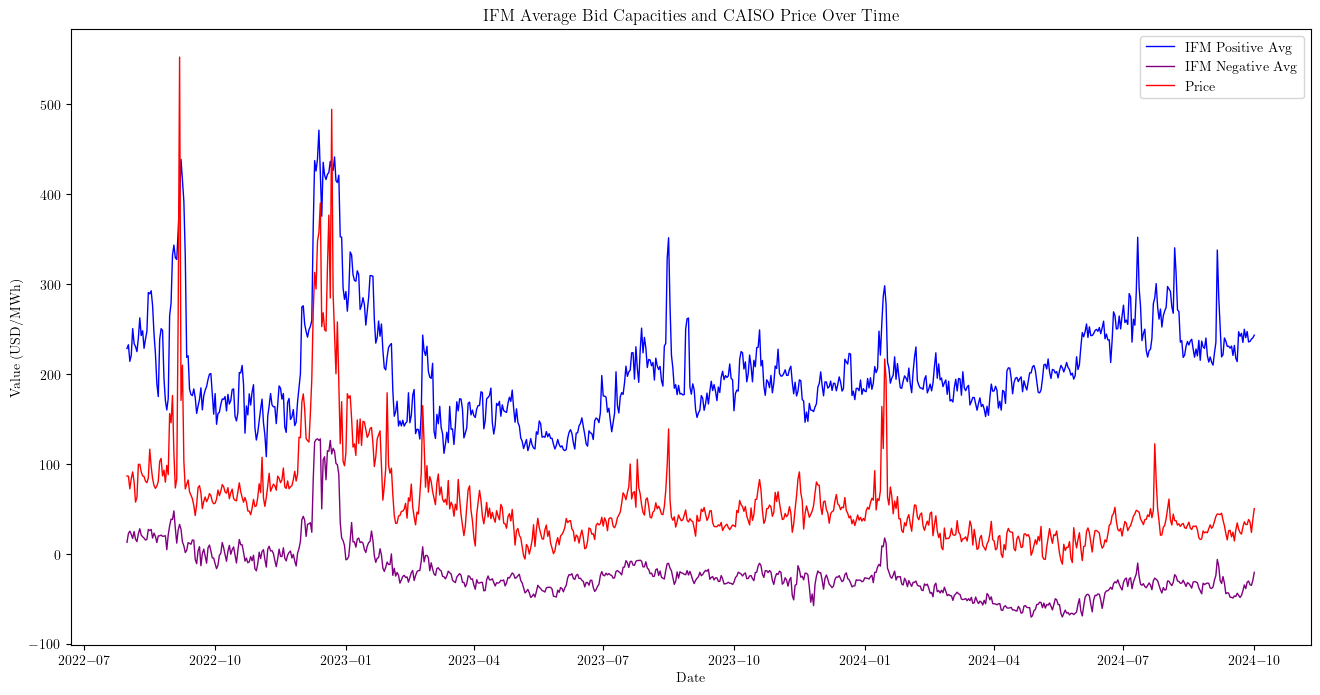

In [110]:
# Plot IFM average bid capacities and price
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot IFM positive and negative average bid capacities
ax1.plot(
    df_weighted_daily.index,
    df_weighted_daily["bid_ifm_pos_avg"],
    label="IFM Positive Avg",
    color="blue",
    linewidth=1,
)
ax1.plot(
    df_weighted_daily.index,
    df_weighted_daily["bid_ifm_neg_avg"],
    label="IFM Negative Avg",
    color="purple",
    linewidth=1,
)

# Plot price
ax1.plot(
    df_weighted_daily.index,
    df_weighted_daily["price"],
    label="Price",
    color="red",
    linewidth=1,
    alpha=1,
)

# Set title and labels for the y-axis
ax1.set_title("IFM Average Bid Capacities and CAISO Price Over Time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Value (USD/MWh)")

# Add legend
ax1.legend(loc="upper right")

plt.show()

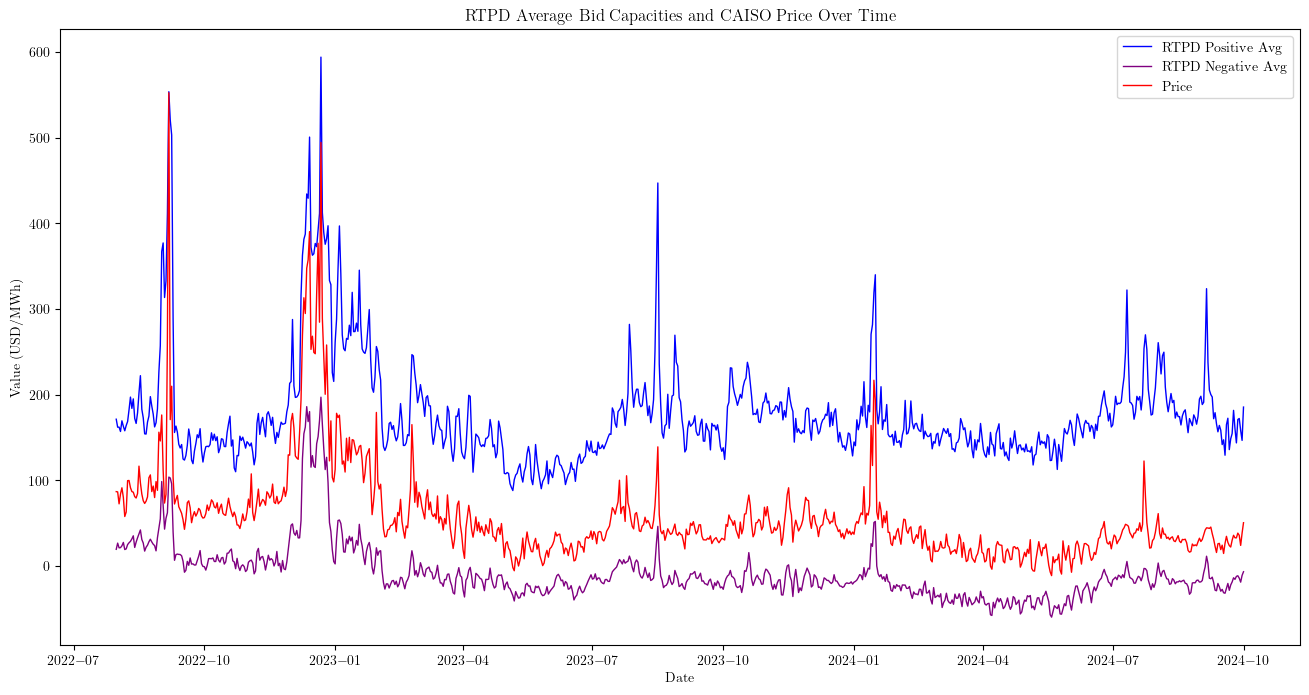

In [111]:
# Plot RTPD average bid capacities and price
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot RTPD positive and negative average bid capacities
ax1.plot(
    df_weighted_daily.index,
    df_weighted_daily["bid_rtpd_pos_avg"],
    label="RTPD Positive Avg",
    color="blue",
    linewidth=1,
)
ax1.plot(
    df_weighted_daily.index,
    df_weighted_daily["bid_rtpd_neg_avg"],
    label="RTPD Negative Avg",
    color="purple",
    linewidth=1,
)

# Plot price
ax1.plot(
    df_weighted_daily.index,
    df_weighted_daily["price"],
    label="Price",
    color="red",
    linewidth=1,
    alpha=1,
)

# Set title and labels for the y-axis
ax1.set_title("RTPD Average Bid Capacities and CAISO Price Over Time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Value (USD/MWh)")

# Add legend
ax1.legend(loc="upper right")

plt.show()

In [112]:
print(df.resample(AGGREGATION_GRANULARITY).min())

            tot_energy_ifm  tot_energy_ruc  tot_energy_rtpd  tot_energy_rtd  \
datetime                                                                      
2022-07-31         -1400.0         -1400.0          -1161.0         -1205.0   
2022-08-01         -1014.0         -1014.0           -879.0          -839.0   
2022-08-02         -1341.0         -1341.0           -963.0          -956.0   
2022-08-03         -1211.0         -1211.0          -1256.0         -1156.0   
2022-08-04          -917.0          -917.0          -1055.0         -1180.0   
...                    ...             ...              ...             ...   
2024-09-27         -4396.0         -4396.0          -6046.0         -5658.0   
2024-09-28         -4593.0         -4593.0          -6255.0         -6045.0   
2024-09-29         -4761.0         -4761.0          -6266.0         -6392.0   
2024-09-30         -4798.0         -4798.0          -5559.0         -5684.0   
2024-10-01         -5463.0         -5463.0          

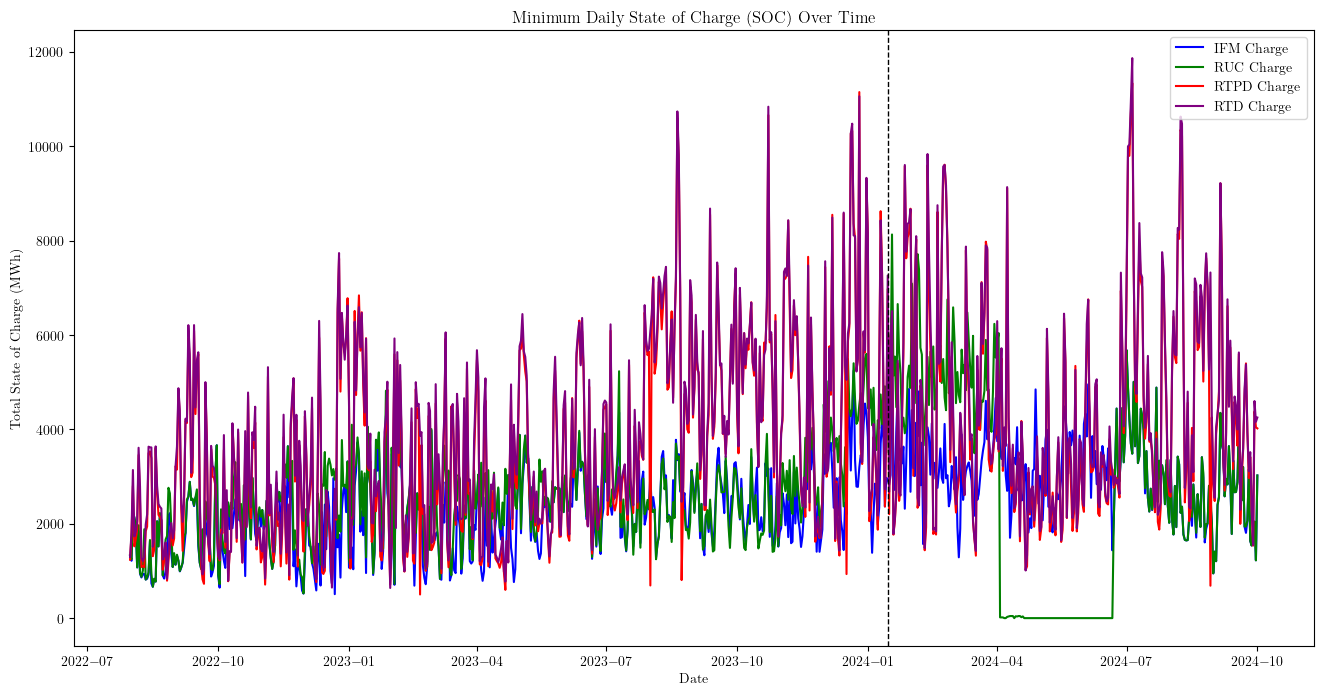

In [113]:
# Aggregate daily SOE
df_daily_soe = df.resample(AGGREGATION_GRANULARITY).min()

# # Filter for January 2024
# df_daily_soe = df_daily_soe.loc["2024-01-01":"2024-01-31"]

# Plot daily SOE
fig, ax = plt.subplots(figsize=(16, 8))

# Plot each SOE component
ax.plot(
    df_daily_soe.index, df_daily_soe["tot_charge_ifm"], label="IFM Charge", color="blue"
)
ax.plot(
    df_daily_soe.index,
    df_daily_soe["tot_charge_ruc"],
    label="RUC Charge",
    color="green",
)
ax.plot(
    df_daily_soe.index,
    df_daily_soe["tot_charge_rtpd"],
    label="RTPD Charge",
    color="red",
)
ax.plot(
    df_daily_soe.index,
    df_daily_soe["tot_charge_rtd"],
    label="RTD Charge",
    color="purple",
)

# Plot a vertical line on January 15, 2024
ax.axvline(pd.Timestamp("2024-01-15"), color="black", linestyle="--", linewidth=1)

# Set title and labels
ax.set_title("Minimum Daily State of Charge (SOC) Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Total State of Charge (MWh)")

# Add legend
ax.legend(loc="upper right")

plt.show()

## In-Depth Analysis since July 1, 2023

In [114]:
# filter to dates since July11, 2023
recent_df = df_weighted_daily[df_weighted_daily.index >= pd.Timestamp("2023-07-01")]
recent_df.columns

Index(['tot_energy_ifm', 'tot_energy_ruc', 'tot_energy_rtpd', 'tot_energy_rtd',
       'tot_charge_ifm', 'tot_charge_ruc', 'tot_charge_rtpd', 'tot_charge_rtd',
       'as_ru_ifm', 'as_rd_ifm', 'as_sr_ifm', 'as_nr_ifm', 'as_ru_rtpd',
       'as_rd_rtpd', 'as_sr_rtpd', 'as_nr_rtpd', 'tot_energy_hybrid_ifm',
       'tot_energy_hybrid_ruc', 'tot_energy_hybrid_rtpd',
       'tot_energy_hybrid_rtd', 'tot_charge_hybrid_ifm',
       'tot_charge_hybrid_ruc', 'tot_charge_hybrid_rtpd',
       'tot_charge_hybrid_rtd', 'as_ru_hybrid_ifm', 'as_rd_hybrid_ifm',
       'as_sr_hybrid_ifm', 'as_nr_hybrid_ifm', 'as_ru_hybrid_rtpd',
       'as_rd_hybrid_rtpd', 'as_sr_hybrid_rtpd', 'as_nr_hybrid_rtpd',
       'bid_ifm_pos_ss', 'bid_ifm_pos_1', 'bid_ifm_pos_2', 'bid_ifm_pos_3',
       'bid_ifm_pos_4', 'bid_ifm_pos_5', 'bid_ifm_pos_6', 'bid_ifm_pos_7',
       'bid_ifm_pos_8', 'bid_ifm_pos_9', 'bid_ifm_pos_10', 'bid_ifm_pos_11',
       'bid_ifm_neg_ss', 'bid_ifm_neg_1', 'bid_ifm_neg_2', 'bid_ifm_neg_3',
      

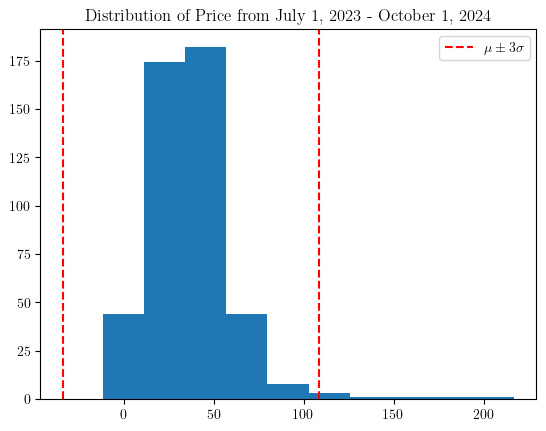

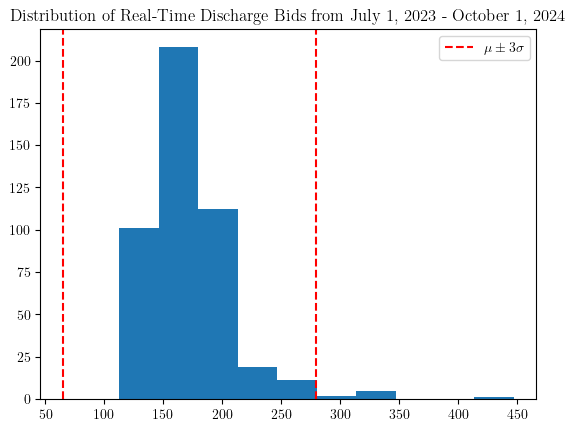

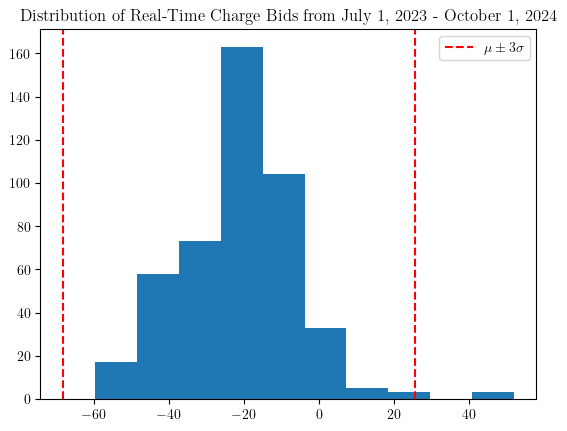

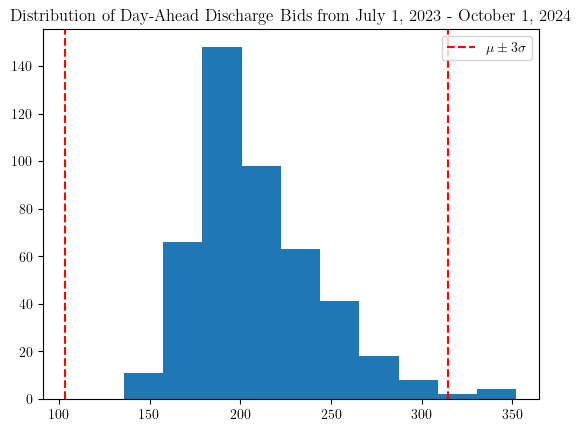

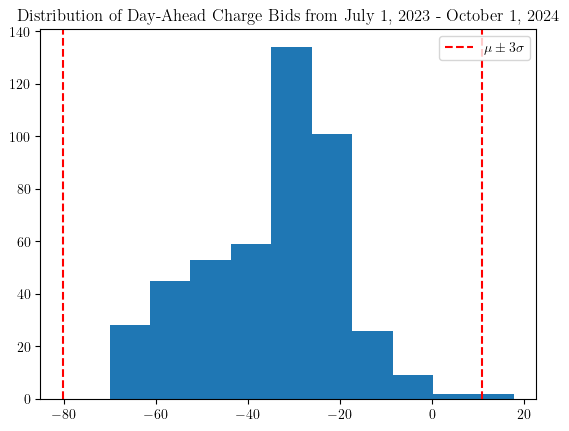

In [115]:
def plot_price_distribution(
    data: pd.DataFrame = None, interest_col: str = None, description: str = None
):
    plt.hist(data[interest_col])
    abnormality_threshold = np.mean(data[interest_col]) + 3 * np.std(data[interest_col])
    plt.axvline(
        x=abnormality_threshold, color="red", linestyle="--", label=r"$\mu \pm 3\sigma$"
    )
    abnormality_lower_threshold = np.mean(data[interest_col]) - 3 * np.std(
        data[interest_col]
    )
    plt.axvline(x=abnormality_lower_threshold, color="red", linestyle="--")
    plt.legend(loc="upper right")
    plt.title(f"Distribution of {description} from July 1, 2023 - October 1, 2024")
    plt.show()


cols = [
    "price",
    "bid_rtpd_pos_avg",
    "bid_rtpd_neg_avg",
    "bid_ifm_pos_avg",
    "bid_ifm_neg_avg",
]
desc = [
    "Price",
    "Real-Time Discharge Bids",
    "Real-Time Charge Bids",
    "Day-Ahead Discharge Bids",
    "Day-Ahead Charge Bids",
]
for col, d in zip(cols, desc):
    plot_price_distribution(recent_df, col, d)

[Timestamp('2023-08-16 00:00:00'), Timestamp('2024-01-13 00:00:00'), Timestamp('2024-01-14 00:00:00'), Timestamp('2024-01-15 00:00:00'), Timestamp('2024-01-16 00:00:00'), Timestamp('2024-07-23 00:00:00')]


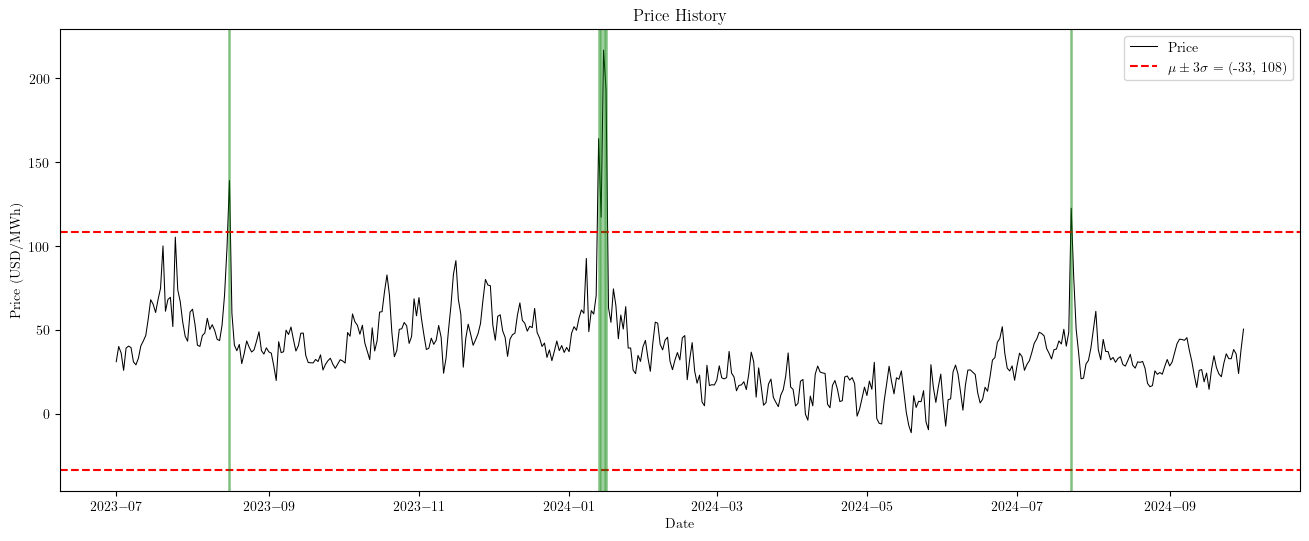

[Timestamp('2023-07-27 00:00:00'), Timestamp('2023-08-15 00:00:00'), Timestamp('2023-08-16 00:00:00'), Timestamp('2024-01-14 00:00:00'), Timestamp('2024-01-15 00:00:00'), Timestamp('2024-01-16 00:00:00'), Timestamp('2024-07-11 00:00:00'), Timestamp('2024-09-05 00:00:00')]


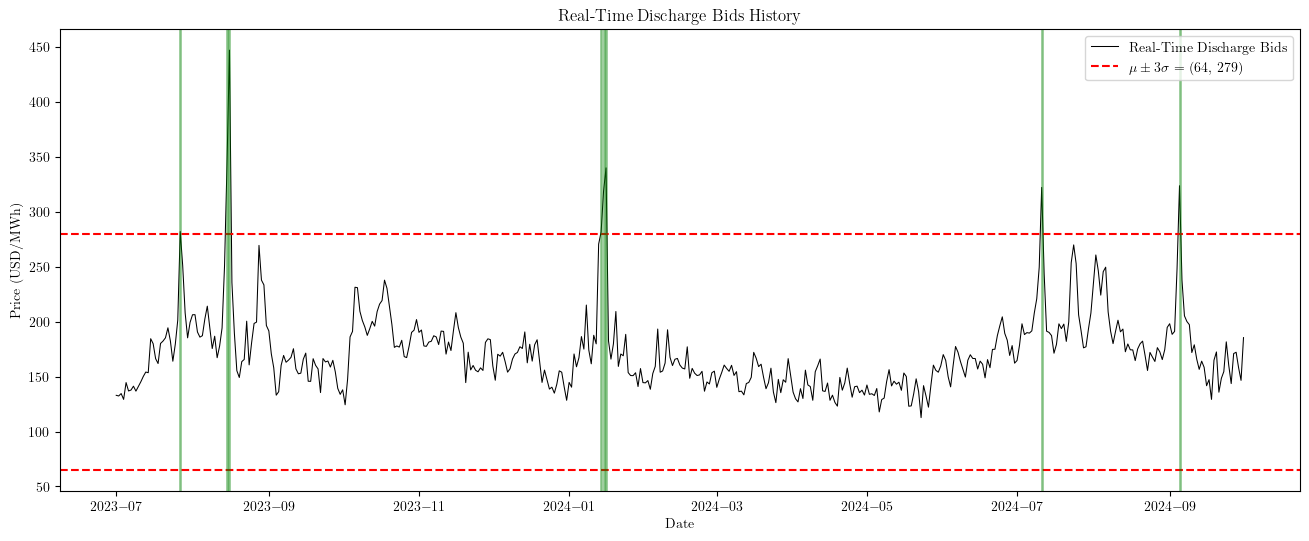

[Timestamp('2023-08-15 00:00:00'), Timestamp('2023-08-16 00:00:00'), Timestamp('2024-01-13 00:00:00'), Timestamp('2024-01-15 00:00:00'), Timestamp('2024-01-16 00:00:00')]


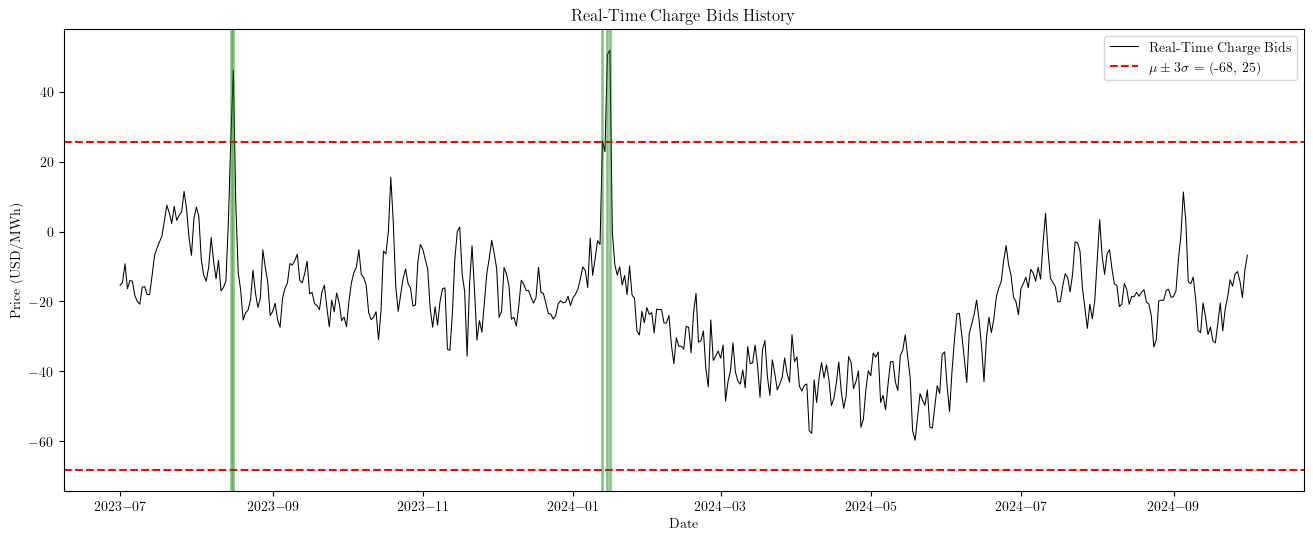

[Timestamp('2023-08-15 00:00:00'), Timestamp('2023-08-16 00:00:00'), Timestamp('2024-07-11 00:00:00'), Timestamp('2024-08-06 00:00:00'), Timestamp('2024-09-05 00:00:00')]


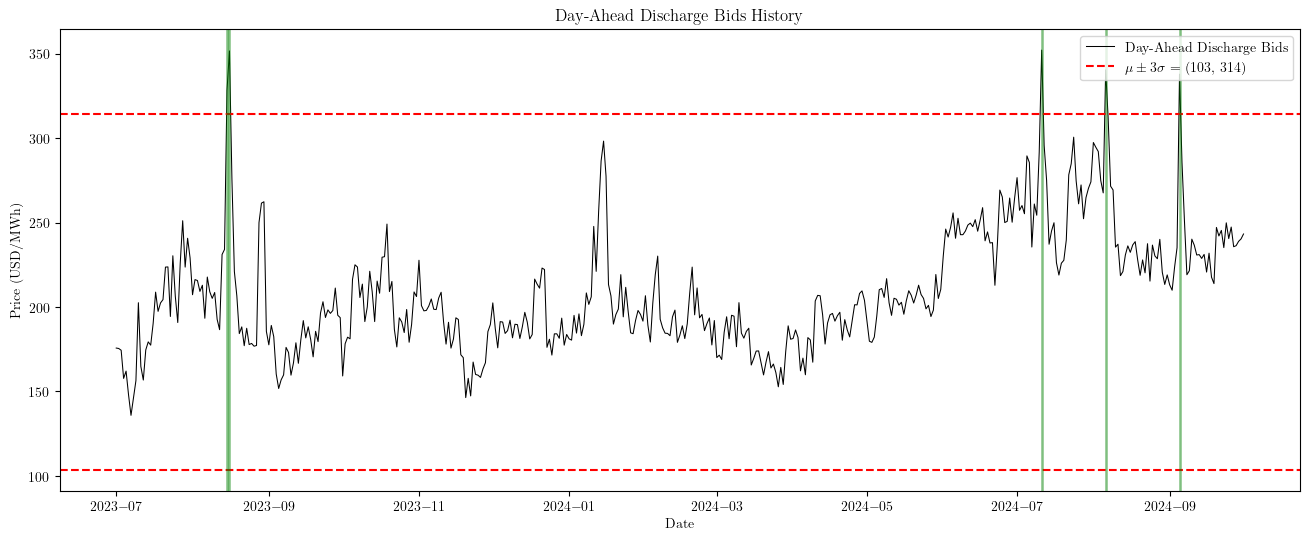

[Timestamp('2024-01-15 00:00:00'), Timestamp('2024-01-16 00:00:00')]


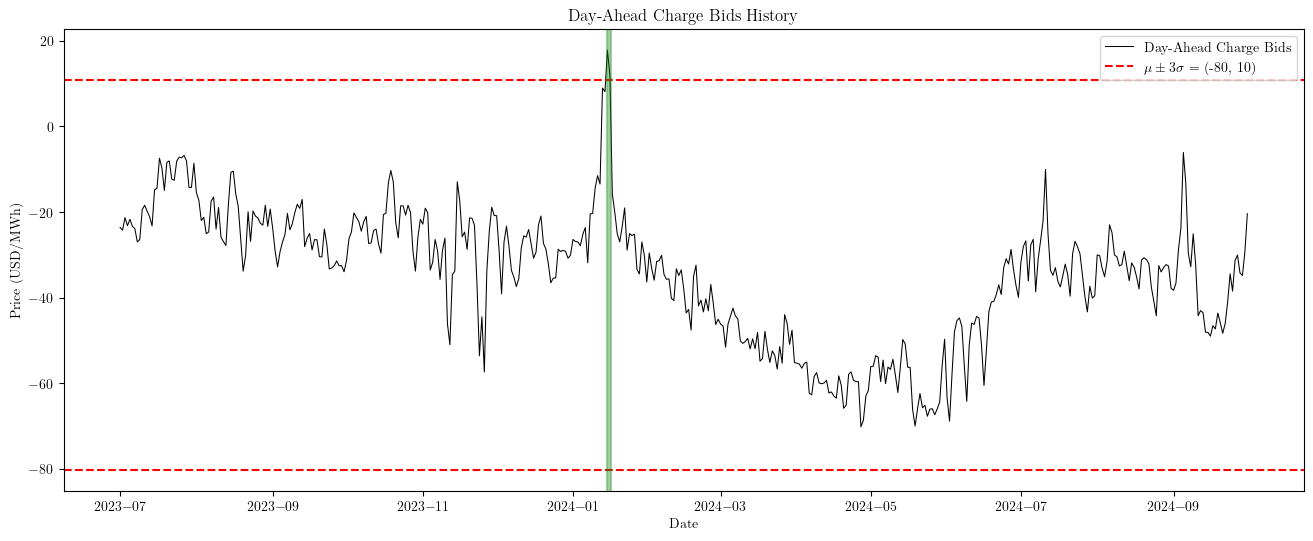

In [131]:
def plot_price_history(
    data: pd.DataFrame = None, interest_col: str = None, description: str = None
):
    # Plot price history with abnormality threshold
    fig, ax = plt.subplots(figsize=(16, 6))

    # Plot the price history
    ax.plot(
        data.index, data[interest_col], label=description, color="black", linewidth=0.75
    )

    abnormality_threshold = np.mean(data[interest_col]) + 3 * np.std(data[interest_col])
    abnormality_lower_threshold = np.mean(data[interest_col]) - 3 * np.std(
        data[interest_col]
    )

    # Plot the horizontal line at abnormality_threshold
    ax.axhline(
        y=abnormality_threshold,
        color="red",
        linestyle="--",
        label=rf"$\mu \pm 3\sigma$ = ({int(abnormality_lower_threshold)}, {int(abnormality_threshold)})",
    )
    ax.axhline(
        y=abnormality_lower_threshold,
        color="red",
        linestyle="--",
        # label=rf"$\mu - 3\sigma$ = {int(abnormality_lower_threshold)}",
    )

    # Plot vertical lines at dates where price exceeds abnormality_threshold
    exceed_dates = data[data[interest_col] > abnormality_threshold].index
    for date in exceed_dates:
        ax.axvline(x=date, color="green", linestyle="-", alpha=0.5, linewidth=1.8)

    # Set title and labels
    ax.set_title(f"{description} History")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price (USD/MWh)")

    # Add legend
    ax.legend(loc="upper right")
    print(list(exceed_dates))

    plt.show()


cols = [
    "price",
    "bid_rtpd_pos_avg",
    "bid_rtpd_neg_avg",
    "bid_ifm_pos_avg",
    "bid_ifm_neg_avg",
]
desc = [
    "Price",
    "Real-Time Discharge Bids",
    "Real-Time Charge Bids",
    "Day-Ahead Discharge Bids",
    "Day-Ahead Charge Bids",
]
for col, d in zip(cols, desc):
    plot_price_history(recent_df, col, d)

In [148]:
def plot_bids_filtered(
    data: pd.DataFrame = None,
    upper_threshold: float = None,
    lower_threshold: float = None,
    start_date: pd.Timestamp = None,
    end_date: pd.Timestamp = None,
    filter_col: str = "price",
    description: str = "",
):

    # filter data for only rows we want in this plot
    filtered_df = data.copy()
    if upper_threshold != None:
        filtered_df = filtered_df[filtered_df[filter_col] <= upper_threshold]
    if lower_threshold != None:
        filtered_df = filtered_df[filtered_df[filter_col] >= lower_threshold]
    if start_date != None:
        filtered_df = filtered_df[filtered_df.index >= start_date]
    if end_date != None:
        filtered_df = filtered_df[filtered_df.index <= end_date]

    # Calculate the average bid distribution for the remaining days
    average_bid_distribution = filtered_df.mean()

    # Extract the relevant columns and align segments by suffix

    suffixes = ["ss"] + [str(i) for i in range(1, 12)]
    x_markers = [bid_segments[s] for s in suffixes]

    rtpd_pos_columns = [f"bid_rtpd_pos_{suffix}" for suffix in suffixes]
    rtpd_neg_columns = [f"bid_rtpd_neg_{suffix}" for suffix in suffixes]
    ifm_pos_columns = [f"bid_ifm_pos_{suffix}" for suffix in suffixes]
    ifm_neg_columns = [f"bid_ifm_neg_{suffix}" for suffix in suffixes]

    max_y_lim = max(
        max(
            average_bid_distribution[rtpd_pos_columns]
            / average_bid_distribution["bid_rtpd_pos_tot"]
        ),
        max(
            average_bid_distribution[ifm_pos_columns]
            / average_bid_distribution["bid_ifm_pos_tot"]
        ),
        max(
            average_bid_distribution[rtpd_neg_columns]
            / average_bid_distribution["bid_rtpd_neg_tot"]
        ),
        max(
            average_bid_distribution[ifm_neg_columns]
            / average_bid_distribution["bid_ifm_neg_tot"]
        ),
    )

    max_y_lim = math.ceil(max_y_lim * 10) / 10
    max_y_lim = 0.5

    # Create a 2x2 figure

    fig, axs = plt.subplots(
        2, 2, figsize=(12, 8), sharex=True, sharey=False, gridspec_kw={"hspace": 0}
    )

    # Plot the stacked distribution for RTPD positive bids

    (
        average_bid_distribution[rtpd_pos_columns]
        / average_bid_distribution["bid_rtpd_pos_tot"]
    ).plot(kind="bar", stacked=True, ax=axs[0, 0], width=1.0)

    axs[0, 0].set_xlabel("Bid Segments")

    axs[0, 0].set_ylabel("Positive Bid Seg. Prop.")

    axs[0, 0].set_ylim((0, max_y_lim))

    axs[0, 0].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)

    axs[0, 0].grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    print(
        "RTPD Discharge Witheld:",
        str(
            (
                average_bid_distribution["bid_rtpd_pos_9"]
                + average_bid_distribution["bid_rtpd_pos_10"]
            )
            / average_bid_distribution["bid_rtpd_pos_tot"]
        ),
    )
    print(
        "IFM Discharge Witheld:",
        str(
            (
                average_bid_distribution["bid_ifm_pos_9"]
                + average_bid_distribution["bid_ifm_pos_10"]
            )
            / average_bid_distribution["bid_ifm_pos_tot"]
        ),
    )
    print(
        "RTPD Charge Positive:",
        str(
            (
                average_bid_distribution["bid_rtpd_neg_5"]
                + average_bid_distribution["bid_rtpd_neg_6"]
                + average_bid_distribution["bid_rtpd_neg_7"]
                + average_bid_distribution["bid_rtpd_neg_8"]
                + average_bid_distribution["bid_rtpd_neg_9"]
                + average_bid_distribution["bid_rtpd_neg_10"]
                + average_bid_distribution["bid_rtpd_neg_11"]
            )
            / average_bid_distribution["bid_rtpd_neg_tot"]
        ),
    )
    print(
        "IFM Charge Positive:",
        str(
            (
                average_bid_distribution["bid_ifm_neg_5"]
                + average_bid_distribution["bid_ifm_neg_6"]
                + average_bid_distribution["bid_ifm_neg_7"]
                + average_bid_distribution["bid_ifm_neg_8"]
                + average_bid_distribution["bid_ifm_neg_9"]
                + average_bid_distribution["bid_ifm_neg_10"]
                + average_bid_distribution["bid_ifm_neg_11"]
            )
            / average_bid_distribution["bid_ifm_neg_tot"]
        ),
    )

    print(
        "RTPD Discharge Ratio:",
        average_bid_distribution["bid_rtpd_pos_avg"]
        / average_bid_distribution["price"],
    )
    print(
        "IFM Discharge Ratio:",
        average_bid_distribution["bid_ifm_pos_avg"] / average_bid_distribution["price"],
    )
    print(
        "RTPD Charge Ratio:",
        average_bid_distribution["bid_rtpd_neg_avg"]
        / average_bid_distribution["price"],
    )
    print(
        "IFM Charge Ratio:",
        average_bid_distribution["bid_ifm_neg_avg"] / average_bid_distribution["price"],
    )

    print(
        "RTPD Discharge Difference:",
        average_bid_distribution["bid_rtpd_pos_avg"]
        - average_bid_distribution["price"],
    )
    print(
        "IFM Discharge Difference:",
        average_bid_distribution["bid_ifm_pos_avg"] - average_bid_distribution["price"],
    )
    print(
        "RTPD Charge Difference:",
        average_bid_distribution["bid_rtpd_neg_avg"]
        - average_bid_distribution["price"],
    )
    print(
        "IFM Charge Difference:",
        average_bid_distribution["bid_ifm_neg_avg"] - average_bid_distribution["price"],
    )
    print("Average RTPD Charge Bid:", average_bid_distribution["bid_rtpd_neg_avg"])
    print("Average IFM Charge Bid:", average_bid_distribution["bid_ifm_neg_avg"])
    print("Average RTPD Discharge Bid:", average_bid_distribution["bid_rtpd_pos_avg"])
    print("Average IFM Discharge Bid:", average_bid_distribution["bid_ifm_pos_avg"])
    print("Average Price:", average_bid_distribution["price"])

    # Plot the stacked distribution for IFM positive bids

    (
        average_bid_distribution[ifm_pos_columns]
        / average_bid_distribution["bid_ifm_pos_tot"]
    ).plot(kind="bar", stacked=True, ax=axs[0, 1], width=1.0)

    axs[0, 1].set_ylim((0, max_y_lim))

    axs[0, 1].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)

    axs[0, 1].grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    # Plot the stacked distribution for RTPD negative bids

    (
        average_bid_distribution[rtpd_neg_columns]
        / average_bid_distribution["bid_rtpd_neg_tot"]
    ).plot(kind="bar", stacked=True, ax=axs[1, 0], width=1.0)

    axs[1, 0].set_xlabel("RTPD Bid Segments")

    axs[1, 0].set_ylabel("Negative Bid Seg. Prop.")

    axs[1, 0].invert_yaxis()

    axs[1, 0].set_ylim((max_y_lim, 0))

    axs[1, 0].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)

    axs[1, 0].grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    # Plot the stacked distribution for IFM negative bids

    (
        average_bid_distribution[ifm_neg_columns]
        / average_bid_distribution["bid_ifm_neg_tot"]
    ).plot(kind="bar", stacked=True, ax=axs[1, 1], width=1.0)

    axs[1, 1].set_xlabel("IFM Bid Segments")

    axs[1, 1].invert_yaxis()

    axs[1, 1].set_ylim((max_y_lim, 0))

    axs[1, 1].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)

    axs[1, 1].grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    if description != "":
        description = " for " + description

    fig.suptitle(f"RTPD and IFM Bid Segment Composition {description}")

    plt.xticks(np.arange(0, 12), x_markers)

    plt.tight_layout()

    plt.show()

RTPD Discharge Witheld: 0.18289731505735252
IFM Discharge Witheld: 0.2604351828680362
RTPD Charge Positive: 0.47472106535588376
IFM Charge Positive: 0.39383476769935133
RTPD Discharge Ratio: 4.85514333993178
IFM Discharge Ratio: 5.947954449304743
RTPD Charge Ratio: -0.6424106737417165
IFM Charge Ratio: -1.0132721900193933
RTPD Discharge Difference: 134.48924182949833
IFM Discharge Difference: 172.61268487766876
RTPD Charge Difference: -57.29658972631293
IFM Charge Difference: -70.23434060869789
Average RTPD Charge Bid: -22.4109240141067
Average IFM Charge Bid: -35.348674896491666
Average RTPD Discharge Bid: 169.37490754170454
Average IFM Discharge Bid: 207.49835058987497
Average Price: 34.88566571220623


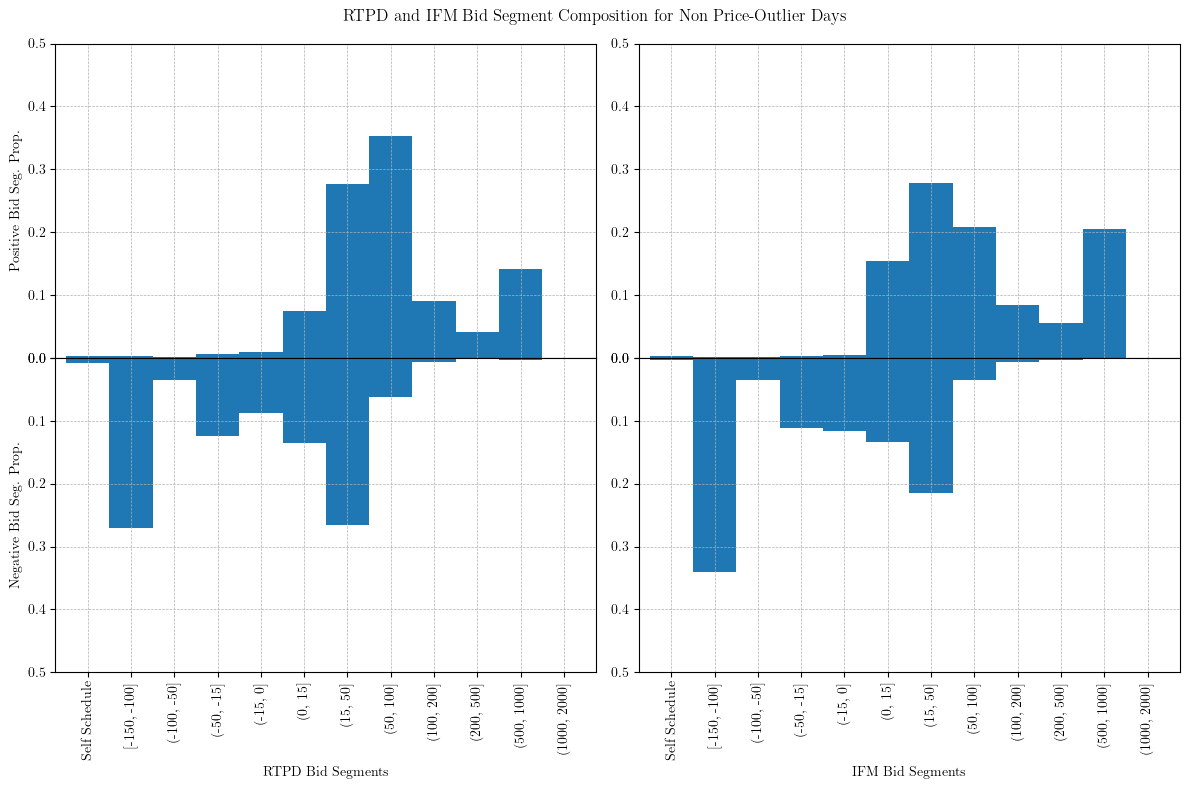

RTPD Discharge Witheld: 0.6571052208041074
IFM Discharge Witheld: 0.4882186841223822
RTPD Charge Positive: 0.6158416151010883
IFM Charge Positive: 0.5196487730810692
RTPD Discharge Ratio: 3.21610450694494
IFM Discharge Ratio: 2.5295399902607385
RTPD Charge Ratio: 0.3323346433428035
IFM Charge Ratio: -0.07522914788761205
RTPD Discharge Difference: 308.0048353209302
IFM Discharge Difference: 212.582805251585
RTPD Charge Difference: -92.79533414702779
IFM Charge Difference: -149.44050498951324
Average RTPD Charge Bid: 46.18946298491666
Average IFM Charge Bid: -10.455707857568807
Average RTPD Discharge Bid: 446.9896324528747
Average IFM Discharge Bid: 351.56760238352945
Average Price: 138.98479713194445


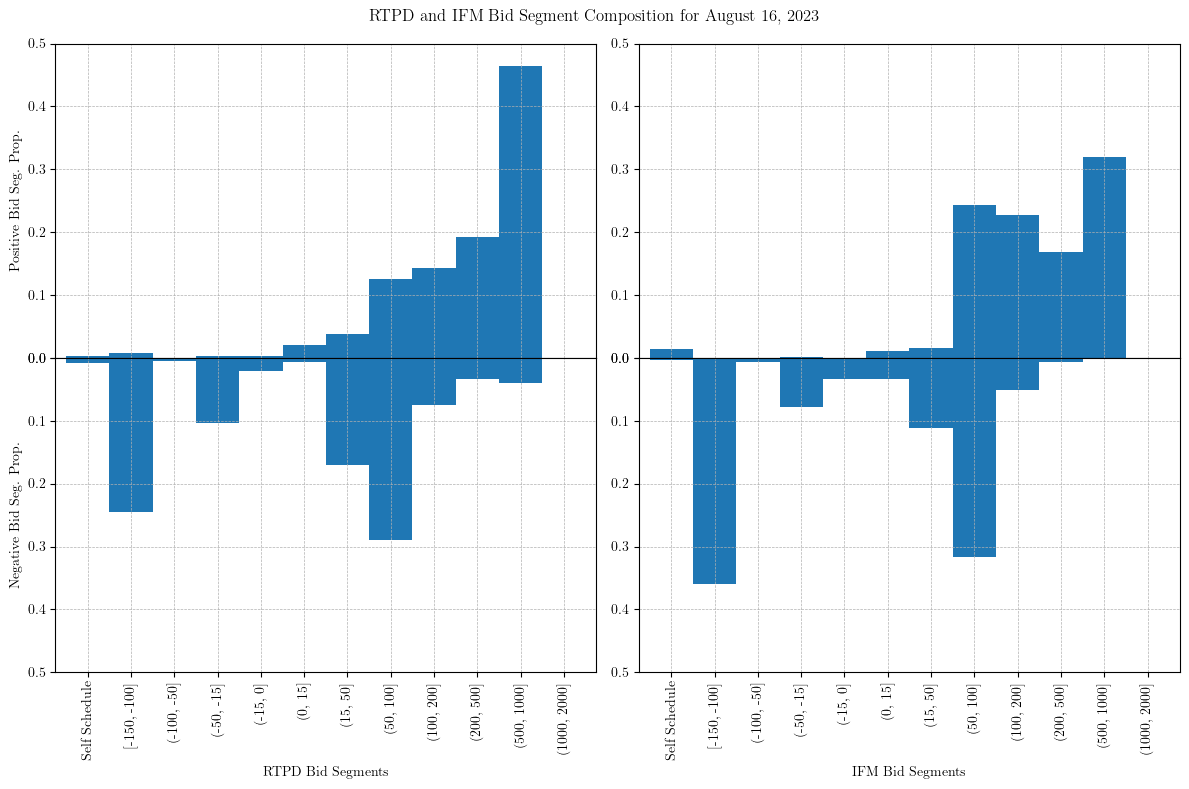

RTPD Discharge Witheld: 0.5633876633995721
IFM Discharge Witheld: 0.42580808189585245
RTPD Charge Positive: 0.6237466838239905
IFM Charge Positive: 0.5872139000419877
RTPD Discharge Ratio: 1.7520269210294481
IFM Discharge Ratio: 1.6189131453770904
RTPD Charge Ratio: 0.21913766595483186
IFM Charge Ratio: 0.067830566005733
RTPD Discharge Difference: 129.92267669994524
IFM Discharge Difference: 106.92549727089514
RTPD Charge Difference: -134.90437873479047
IFM Charge Difference: -161.04469749117615
Average RTPD Charge Bid: 37.85895335722342
Average IFM Charge Bid: 11.718634600837719
Average RTPD Discharge Bid: 302.6860087919591
Average IFM Discharge Bid: 279.688829362909
Average Price: 172.76333209201388


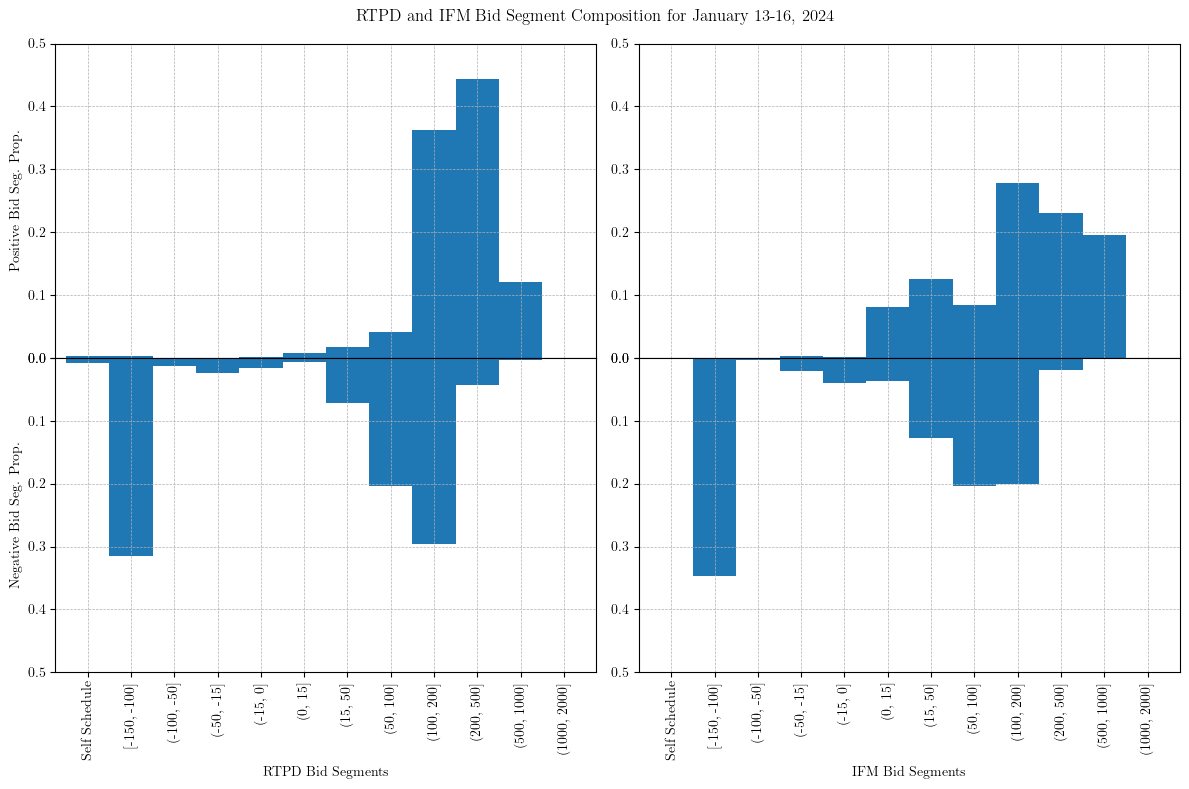

RTPD Discharge Witheld: 0.3623502407984292
IFM Discharge Witheld: 0.3830462314623965
RTPD Charge Positive: 0.6292177140858565
IFM Charge Positive: 0.49689405411569165
RTPD Discharge Ratio: 2.070632061758798
IFM Discharge Ratio: 2.325352219413688
RTPD Charge Ratio: -0.023937973641060765
IFM Charge Ratio: -0.2192188216415095
RTPD Discharge Difference: 131.1242880473814
IFM Discharge Difference: 162.32081252745894
RTPD Charge Difference: -125.40548951784571
IFM Charge Difference: -149.32226081393688
Average RTPD Charge Bid: -2.9317726071314167
Average IFM Charge Bid: -26.848543903222602
Average RTPD Discharge Bid: 253.5980049580957
Average IFM Discharge Bid: 284.79452943817324
Average Price: 122.47371691071429


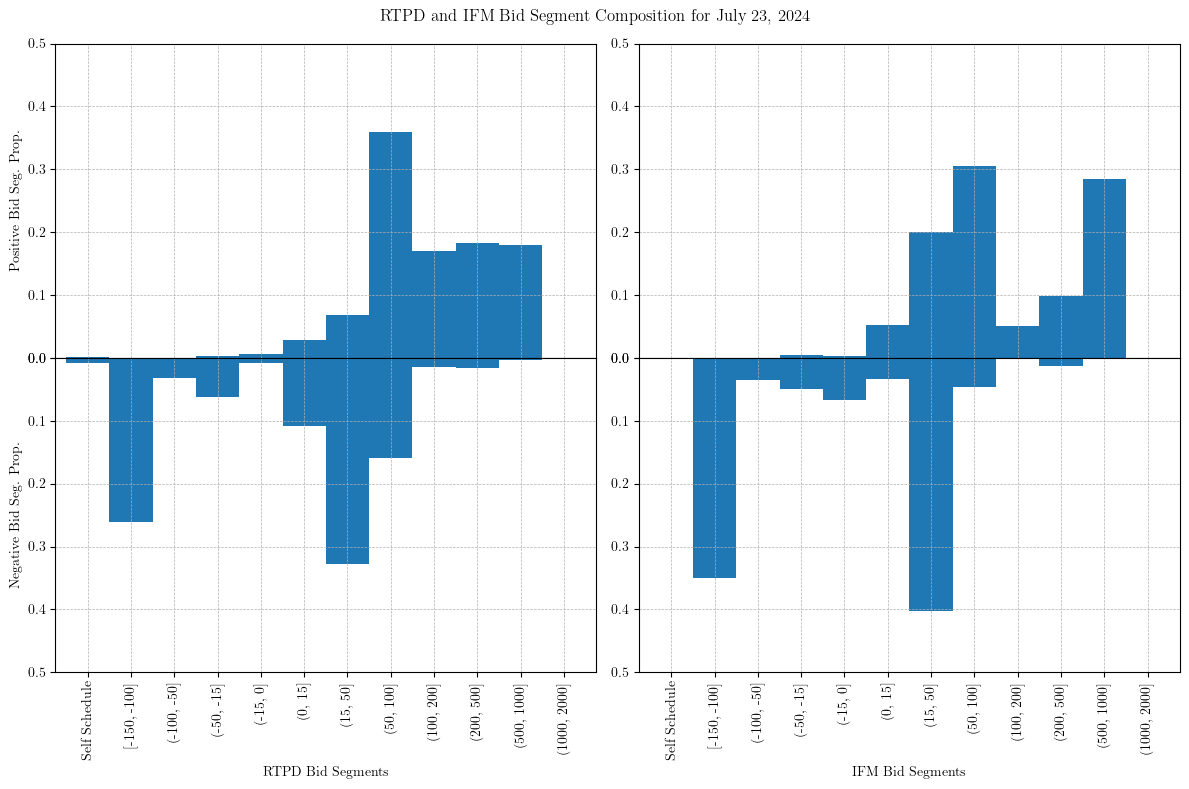

In [149]:
# Average days
plot_bids_filtered(
    data=recent_df,
    upper_threshold=np.mean(df_filtered.price) + 3 * np.std(df_filtered.price),
    lower_threshold=np.mean(df_filtered.price) - 3 * np.std(df_filtered.price),
    filter_col="price",
    description="Non Price-Outlier Days",
)

# Price spike days
plot_bids_filtered(
    data=recent_df,
    start_date=pd.Timestamp("August 16, 2023"),
    end_date=pd.Timestamp("August 16, 2023"),
    filter_col="price",
    description="August 16, 2023",
)
plot_bids_filtered(
    data=recent_df,
    start_date=pd.Timestamp("January 13, 2024"),
    end_date=pd.Timestamp("January 16, 2024"),
    filter_col="price",
    description="January 13-16, 2024",
)
plot_bids_filtered(
    data=recent_df,
    start_date=pd.Timestamp("July 23, 2024"),
    end_date=pd.Timestamp("July 23, 2024"),
    filter_col="price",
    description="July 23, 2024",
)

In [ ]:
def calculate_average_bid_to_price_ratio(data: pd.DataFrame = None,
                                         start_date: pd.Timestamp = None,
                                         end_date: pd.Timestamp = None)